In [1]:
# 引入常用库
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf # 分位数回归所需
import scipy.stats as st
import datetime as dt
import itertools # 迭代器工具

from jqdata import *
import pickle
from IPython.core.display import HTML

import talib # 技术分析


# 画图
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns


# 设置字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

#import plotly.graph_objects as go 

# 设置渲染器 我的终端识别不了所以手动设置 一般可以不用下面这两行
#import plotly.io as pio
#pio.renderers.default = "notebook"

#import cufflinks as cf
#cf.set_config_file(offline=True) # 设置离线

# 图表主题
plt.style.use('ggplot')

# 忽略报错
import warnings
warnings.filterwarnings("ignore") #scipy.special


# k线绘制
from six.moves import xrange, zip
from matplotlib import colors as mcolors
from matplotlib.collections import LineCollection, PolyCollection

def candlestick2_ochl(ax, opens, closes, highs, lows, width=4,
                      colorup='k', colordown='r',
                      alpha=0.75):
    """Represent the open, close as a bar line and high low range as a
    vertical line.
    Preserves the original argument order.
    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    opens : sequence
        sequence of opening values
    closes : sequence
        sequence of closing values
    highs : sequence
        sequence of high values
    lows : sequence
        sequence of low values
    width : int
        size of open and close ticks in points
    colorup : color
        the color of the lines where close >= open
    colordown : color
        the color of the lines where close <  open
    alpha : float
        bar transparency
    Returns
    -------
    ret : tuple
        (lineCollection, barCollection)
    """

    return candlestick2_ohlc(ax, opens, highs, lows, closes, width=width,
                             colorup=colorup, colordown=colordown,
                             alpha=alpha)


def candlestick2_ohlc(ax, opens, highs, lows, closes, width=4,
                      colorup='k', colordown='r',
                      alpha=0.75):
    """Represent the open, close as a bar line and high low range as a
    vertical line.
    NOTE: this code assumes if any value open, low, high, close is
    missing they all are missing
    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    opens : sequence
        sequence of opening values
    highs : sequence
        sequence of high values
    lows : sequence
        sequence of low values
    closes : sequence
        sequence of closing values
    width : int
        size of open and close ticks in points
    colorup : color
        the color of the lines where close >= open
    colordown : color
        the color of the lines where close <  open
    alpha : float
        bar transparency
    Returns
    -------
    ret : tuple
        (lineCollection, barCollection)
    """

    _check_input(opens, highs, lows, closes)

    delta = width / 2.
    barVerts = [((i - delta, open),
                 (i - delta, close),
                 (i + delta, close),
                 (i + delta, open))
                for i, open, close in zip(xrange(len(opens)), opens, closes)
                if open != -1 and close != -1]

    rangeSegments = [((i, low), (i, high))
                     for i, low, high in zip(xrange(len(lows)), lows, highs)
                     if low != -1]

    colorup = mcolors.to_rgba(colorup, alpha)
    colordown = mcolors.to_rgba(colordown, alpha)
    colord = {True: colorup, False: colordown}
    colors = [colord[open < close]
              for open, close in zip(opens, closes)
              if open != -1 and close != -1]

    useAA = 0,  # use tuple here
    lw = 0.5,   # and here
    rangeCollection = LineCollection(rangeSegments,
                                     colors=colors,
                                     linewidths=lw,
                                     antialiaseds=useAA,
                                     )

    barCollection = PolyCollection(barVerts,
                                   facecolors=colors,
                                   edgecolors=colors,
                                   antialiaseds=useAA,
                                   linewidths=lw,
                                   )

    minx, maxx = 0, len(rangeSegments)
    miny = min([low for low in lows if low != -1])
    maxy = max([high for high in highs if high != -1])

    corners = (minx, miny), (maxx, maxy)
    ax.update_datalim(corners)
    ax.autoscale_view()

    # add these last
    ax.add_collection(rangeCollection)
    ax.add_collection(barCollection)
    return rangeCollection, barCollection

def _check_input(opens, closes, highs, lows, miss=-1):
    """Checks that *opens*, *highs*, *lows* and *closes* have the same length.
    NOTE: this code assumes if any value open, high, low, close is
    missing (*-1*) they all are missing
    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    opens : sequence
        sequence of opening values
    highs : sequence
        sequence of high values
    lows : sequence
        sequence of low values
    closes : sequence
        sequence of closing values
    miss : int
        identifier of the missing data
    Raises
    ------
    ValueError
        if the input sequences don't have the same length
    """

    def _missing(sequence, miss=-1):
        """Returns the index in *sequence* of the missing data, identified by
        *miss*
        Parameters
        ----------
        sequence :
            sequence to evaluate
        miss :
            identifier of the missing data
        Returns
        -------
        where_miss: numpy.ndarray
            indices of the missing data
        """
        return np.where(np.array(sequence) == miss)[0]

    same_length = len(opens) == len(highs) == len(lows) == len(closes)
    _missopens = _missing(opens)
    same_missing = ((_missopens == _missing(highs)).all() and
                    (_missopens == _missing(lows)).all() and
                    (_missopens == _missing(closes)).all())

    if not (same_length and same_missing):
        msg = ("*opens*, *highs*, *lows* and *closes* must have the same"
               " length. NOTE: this code assumes if any value open, high,"
               " low, close is missing (*-1*) they all must be missing.")
        raise ValueError(msg)
        

# 根据code画出K线图
def plot_candlestick(symbol:str,end_date:str,show_count:int,timeperiod:list):
    
    max_window = max(timeperiod)+1
    
    # 数据获取
    data = get_price(symbol,end_date=end_date,count=max_window,fields=['close','open','high','low'],panel=False)
    # 获取股票名称
    symbol_name = get_security_info(symbol).display_name
    
    
    fig = plt.figure(figsize=(24, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(symbol_name)
    ax.set_xticks(range(0, len(data.index), 10))
    ax.set_xticklabels(data.index[::10])
    
    # 均线计算
    for i in timeperiod:
        
        sma = talib.SMA(data['close'].values,i)
        ax.plot(sma[-show_count:], label=str(i)+' 日均线')
   
    ax.legend(loc='upper left')
    
    slice_data = data.iloc[-show_count:]
    candlestick2_ochl(ax, slice_data['open'], slice_data['close'], slice_data['high'], slice_data['low'],
                         width=0.5, colorup='r', colordown='green',
                         alpha=0.6)
    plt.grid()

# 根据df画图
def show_df_candlestick(symbol:str,df:pd.DataFrame,timeperiod:list):
    
    max_window = max(timeperiod)+1
    
    # 数据获取
    data = df.copy()
    
    # 获取股票名称
    symbol_name = get_security_info(symbol).display_name
    
    
    fig = plt.figure(figsize=(24, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(symbol_name)
    ax.set_xticks(range(0, len(data.index), 244))
    ax.set_xticklabels(data.index[::10])
    
    # 均线计算
    for i in timeperiod:
        
        sma = talib.SMA(data['close'].values,i)
        ax.plot(sma, label=str(i)+' 日均线')
   
    ax.legend(loc='upper left')
    
    slice_data = data
    candlestick2_ochl(ax, slice_data['open'], slice_data['close'], slice_data['high'], slice_data['low'],
                         width=0.5, colorup='r', colordown='green',
                         alpha=0.6)
    plt.grid()

# 前言


**移动平均（Moving Average，MA）**，又称移动平均线，简称均线。作为技术分析中一种分析时间序列的常用工具，常被应用于股票价格序列。移动平均可过滤高频噪声，反映出中长期低频趋势，辅助投资者做出投资判断。

根据计算方法的不同，流行的移动平均包括**简单移动平均、加权移动平均、指数移动平均**，更高阶的移动平均算法则有**分形自适应移动平均、赫尔移动平均**等。这其中，简单移动平均又最为常见。下图为上证指数日线的 5 个不同计算窗口（20 日，50 日，120 日，200 日，300 日）的简单移动平均线。

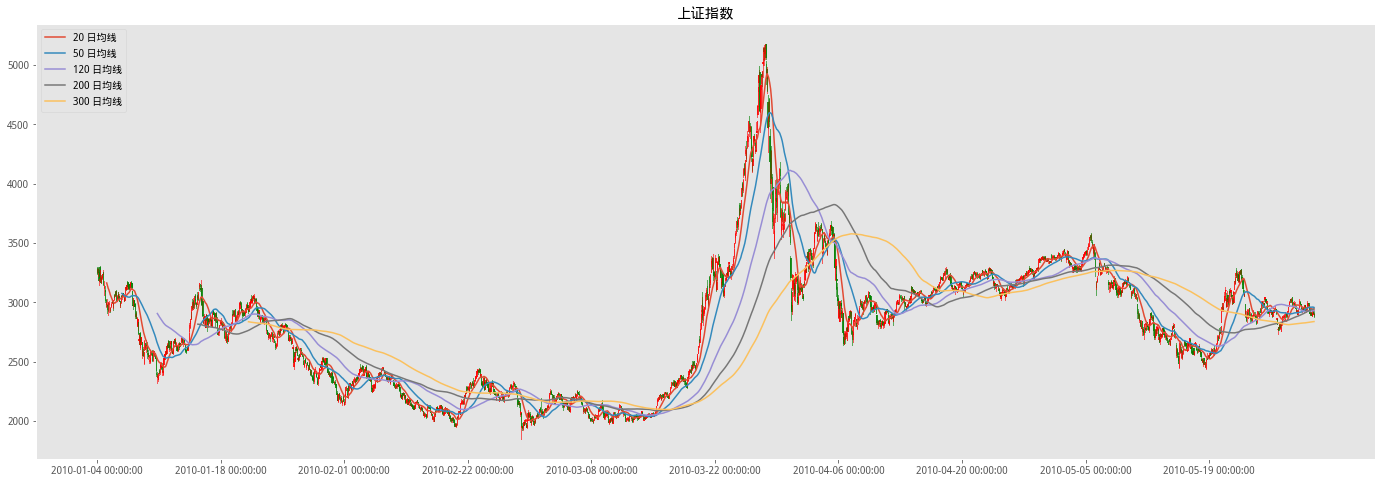

In [2]:
# 传统移动均线比较
SH_df = get_price('000001.XSHG', '2010-01-01', '2019-11-22', fields='close,open,high,low'.split(','))
show_df_candlestick('000001.XSHG',SH_df,timeperiod=[20, 50, 120, 200, 300])

**简单移动平均（Simple Moving Average, SMA）**就是对时间序列直接求**等权重均值**，因此使用简单。但其最令人诟病的就是它的**滞后性**。从上图不难看出，**随着计算窗口 T 的增大，移动平均线越来越平滑，但同时也越来越滞后**。以 120 日均线为例，在 2015 年 6 月份之后的大熊市开始了很长一段时间之后，120 日均线才开始呈现下降趋势。如果我们按照这个趋势进行投资，那这个滞后无疑造成了巨额的亏损。

**事实上，任何移动平均算法都会呈现一定的滞后性。它以滞后性的代价换来了平滑性，移动平均必须在平滑性和滞后性之间取舍。然而，滞后性是怎么产生的呢？简单移动平均在时间上滞后多少呢？有没有什么高级的移动平均算法能在保证平滑性的同时将滞后性减小到最低呢？这些就是本文要回答的问题。**

# 移动平均的本质

**均线的滞后性**

移动平均的本质是一种低通滤波。它的目的是过滤掉时间序列中的高频扰动，保留有用的低频趋势。如何从时间序列中抽取出真正的低频趋势呢？无论采取哪种移动平均算法，理论上的计算方法都相同，下面我们简要说明。同时，我们也会清晰地阐述该计算方法仅在理论上有效，而在实际应用中是无法实现的，并由此揭示产生滞后性的原因。

假设我们有一个时间序列$y=\{\cdots, y_{t-2}, y_{t-1}, y_t, y_{t+1}, y_{t+2},\cdots\}$，如下图所示。另外，假设我们有一个作用在时域 t 上的过滤函数 F（注：这个 F 的具体形式根据不同的移动平均算法而不同）。

<img src="http://p3.pstatp.com/large/pgc-image/aa3d09536c34480aa87304fadd17784a">

在理论上，在任意 t 时刻的低频滤波（用 x_t 表示）在数学上可以表示为该时间序列 y 和过滤函数 F 在整个时域上的卷积，即:
$$x_t=\sum^{\infty}_{i=-\infty}Fy_{t-i}$$
其中，$F_i$ 为过滤函数 F 在时刻 i 的取值。由于在实际中不可能用到无穷多的数据，因此可以考虑给过滤加一个窗函数，即过滤函数 F 只在窗口长度 T 内有效、在窗口之外为 0，如下图所示：
<img src="http://p1.pstatp.com/large/pgc-image/65fb829ccb5947eea22665eac2c4a5db">
加入长度为 T 的窗函数后，在时刻t的低频滤波变为该时间序列 y 和过滤函数 F 在这个窗口内的卷积：
$$x_t=\sum^{t+(T-1)/2}_{i=t-(T-1)/2}F_iy_{t-i}$$
然而，无论是否使用加窗函数，**上述公式最大的问题是，在计算t时刻的低频分量时，利用到了未来的数据。**换句话说，理论上的低通滤波（或者移动平滑）必须要用事后数据，其假设所有数据都发生后再在全局上计算所有时点的低频分量。但这在实时数据中是不可能的，因为在任何当前时刻 t，我们都没有未来数据可以利用。

正因如此，在实际应用中，我们无法使用 t-(T-1)/2 到 t+(T-1)/2 之间的数据，只能退而求其次使用 t-(T-1) 到 t 之间的数据。这相当于我们把计算低频趋势的过滤窗函数在时域上向左平移 (T-1)/2 个单位，如下图所示：
<img scr="http://p1.pstatp.com/large/pgc-image/1a28ef4808564208a23adc031958d931">
如此处理后，对于实时数据，在当前时刻 t 的低频滤波变为该时间序列 y 和过滤函数 F 在 t-T+1 到 t 之间的卷积：
$$x_t=\sum^{t}_{i=t-T+1}F_iy_{t-i}$$
<font color='DarkRed'>**没有未来数据便是滞后的根本原因。**</font>

对于简单移动平均来说，在窗口 T 内，过滤函数在每个时点的取值都是 1/T。利用上述公式计算得到的实际上是 t-(T-1)/2 时刻（而非 t 时刻）的低频趋势，而我们把它当作 t 时刻的低频趋势使用，这便产生了 (T-1)/2 的滞后。当我们使用简单移动平均时，在当前时刻 t，对于给定的时间窗口 T，我们仅能求出 t-(T-1)/2 时刻之前的低频趋势，而无法求出 t-(T-1)/2 之后的低频趋势。这也解释了为什么时间窗口 T 越大，滞后 (T-1)/2 越多。这就是为什么看股票数据里面 MA20、MA30、MA50 等日均线这种，计算均线的窗口 T 越大，得到的移动平滑曲线越滞后。

既然无论如何都没有未来数据，那么是否意味着我们就只能接受移动平均的滞后性呢？答案是否定的。换个角度来考虑这个问题，**滞后性说明由简单移动平均计算得到的低频趋势对近期的最新数据不够敏感。**这是由于它在计算低频趋势时，对窗口内所有的数据点都给予相同的权重。按着这个思路延伸，自然的想法就是**在计算移动平均时，给近期的数据更高的权重，而给窗口内较远的数据更低的权重，以更快的捕捉近期的变化。由此便得到了加权移动平均和指数移动平均。**

# 金叉死叉的实质含义？

本来想展开讲，感觉有点多暂时就这样.....

<font color=Darkred>**"比较T日价格和T-N到T日均价看孰高，若前者大于后者则满仓，前者下于后者则空仓"**</font>

这句话我们我们试着用数学表达是不是就是比较对t日：

$P_t>\frac{\sum^{n-1}_{i=0}P_{t-i}}{n}$

这个不等式是否成立？如果成立，我就在t日满仓，获取t到t+1日的收益，否则就空仓？

很显然这个等式等价于：

$\sum^{n-1}_{i=0}P_{t-i}-n·P_t<0$

然后写成:

$\Rightarrow\sum^{n-1}-{i=0}(P_{t-i}-P_t)<0$

左右同时除以$P_t$,有:

$\Rightarrow\sum^{n-1}-{i=0}(P_{t-i}-1)<0$

我们知道对于x<<1有：

$log(1+x)\approx x$

对于不太大的i,我们可以认为$P_{t-i}$和$P_t$比较接近，亦即我们可以令:

$x \Leftarrow \frac{P_{t-i}}{P_t}-1$

则我们可以将上面的不等式写成:

$\Rightarrow\sum^{n-1}_{i=0}log(\frac{P_{t-i}}{P_t}<0$

左右同时乘以-1,即有:

$\Rightarrow\sum^{n-1}_{i=0}log(\frac{P_t}{P_{t-i}})>0$

很显然，对每一个$log(\frac{P_t}{P_{t-i}})$我们有:

$log(\frac{P_t}{P_{t-i}})=log(\frac{P_t}{P_{t-1}}·\frac{P_{t-1}}{P_{t-2}}\cdots)=log(\frac{P_t}{P_{t-1}})+log(\frac{P_{t-1}}{P_{t-2}})\cdots=r_t+r_{t-1}+\cdots=\sum^{i-1}_{j=0}r_{t-j}$

这里我们采用了通常的对数收益率的定义。将上式代入前面的公式就是:

$\Rightarrow\sum^{n-1}_{i=1}\sum^{i-1}_{j=0}r_{t-j}>0$

这式子可以简化为:

$\Rightarrow\sum^{n-1}_{i=0}(n-i)·r_{t-i}>0$

如果我们把（n-i)看看作是$r_{t-i}$的权重，上面这个式子是不是就相当于比较过去n日的收益率r的一个加权平均$\overline{r}=\sum^{n-1}_{i=0}w_i·r_{t-i}$和0的关系，如果这个加权平均大于0就于t+1日满仓，否则就空仓。

所以**其实单均线可以看作是构造了一个信号，这个信号是过去一段时间窗内的日收益率的加权平均，然后这个信号大于0就在t日满仓，否则就空仓**；然后持续不断地对t+1、t+2日重复计算，从而连续得到每天是满仓还是空仓。

可以进一步想，既然我的投资决策是理性的，就说明这个信号和t+1日预期收益率正相关，否则我就不会在这个信号大于0时满仓、而小于0时空仓了。

所以从这个角度，你就连续地把t日的单均线变成了一个信号，这个信号与t+1日的收益率有相关性，这样你就可以通过滚动地考察t日的信号与t+1日收益率的相性，也就是IC，来验证这个信号是否有效了。

不仅如此，通过上面的推导，把单均线交叉变为了我们量化分析中熟悉的收益率。这样我就能看明白单均线策略的信号，实际相当于过去一段时间收益率的加权平均（也就是**卷积**），且权重是随着时间的推移逐渐降低的。这时候就可以思考，这样的权重分布（也就是**窗函数**）是否有意义。

也就是说，通过推导，说明了单均线其实相当于一个**窗函数**和**收益率时间序列**的**卷积**，而这里的窗函数是一个直角三角形，这样你就可以看出来，基于某个均线模型，哪段时间的收益率对t+1日的收益率贡献的信息量更大，从而知道这个均线模型的优缺点。

通过这样的推导，我就可以所有的均线模型归纳成卷积形式：$w\bigotimes R$,通过分析窗函数w，就可以知道这个均线的意义。而且，卷积存在结合律和分配率，通过简单变化就可以变成各种均线的衍生指标，比如MACD。

对于一个长线=200天，短线=50天的双均线，其意义就是：
>取过去200天的日收益率r计算其加权平均数，其中：
>
>对于0-50日，权重从0线性上升；
>
>对于50-200日，权重线性下降到0
>
>权重之和=1


# 均线的常见算法

## 加权移动平均

在计算**加权移动平均（Weighted Moving Average, WMA）**时，窗口内的过滤函数的取值从当前数据到之前第 T-1 期的数据依次线性递减。因此，第 t-i 期的 F_(t-i) 为 2(T-i)/(T(T+1))，i = 0, 1,……, T-1。该权重是 i 的单调线性递减函数。下图为 T = 15 时不同 i 的取值对应的权重（图片来自 wiki）。
<img src="http://p9.pstatp.com/large/pgc-image/8a6230ee29ec4209b311680739f3172c">
在确定了权重后，t 时刻的加权移动平均（记为 $WMA_t$）由下式得到：
$$WMA_t=\frac{Ty_t+(T-1)y_{t-1}+\ldots+2y_{t-T+2}+y_{t-T+1}}{T(T+1)/2}$$
值得一提的是，由于严格的按照线性递减，因此权重会最终在当前时刻之前的第 T 期时点衰减为 0。

以上证指数过去 10 年的日数据为例，下图比较了 T = 100 时的简单移动平均和加权移动平均的过滤效果。**加权移动平均比简单移动平均对近期的变化更加敏感，尤其是在牛熊市转换的时候，加权移动平均的滞后性小于简单移动平均。但是，由于仅采用线性权重衰减，加权移动平均仍然呈现出滞后性。**

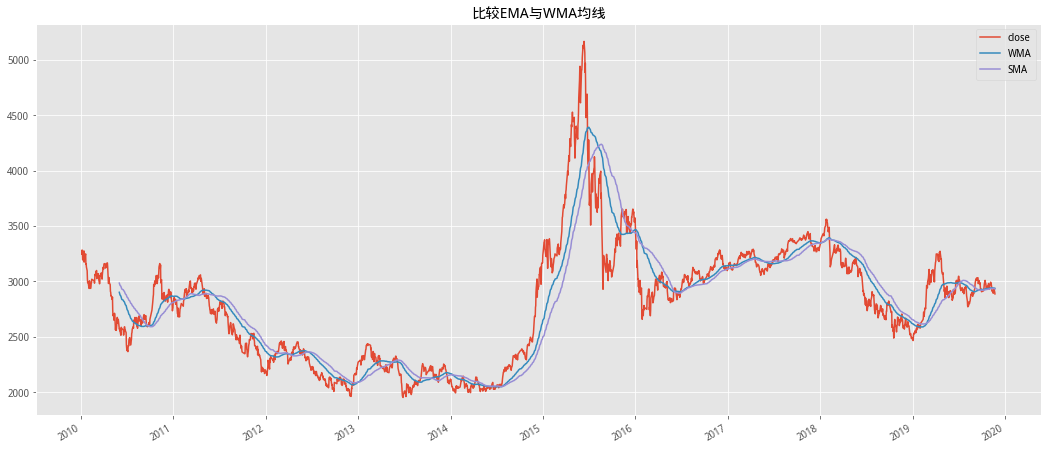

In [3]:
# WMA与SMA比较

T = 100
COMPARE = SH_df[['close']]
WMA = talib.WMA(COMPARE['close'].values, timeperiod=T)
SMA = talib.SMA(COMPARE['close'].values, timeperiod=T)
COMPARE['WMA'] = WMA
COMPARE['SMA'] = SMA

COMPARE.plot(figsize=(18,8),title='比较EMA与WMA均线')

## 指数移动平均

**指数移动平均（Exponential Moving Average, EMA）**和加权移动平均类似，但不同之处是各数值的加权按**指数递减**，而非线性递减。此外，在指数衰减中，无论往前看多远的数据，该期数据的系数都不会衰减到 0，而仅仅是向 0 逼近。因此，指数移动平均实际上是一个**无穷级数**，即无论多久远的数据都会在计算当期的指数移动平均数值时有一定的作用，只不过离当前太远的数据权重非非常低，因此它们的作用往往可以忽略。

在实际应用中，t 时刻的指数移动平均（记为 $EMA_t$）可以按如下方法得到：
$$EMA_t=\begin{cases}
close_t,\quad t= 0 \\\\
\alpha*close_t+(1-\alpha)*EMA_{t-1},\quad t>0
\end{cases}$$

其中 alpha 表示权重的衰减程度，取值在 0 和 1 之间。**alpha 越大，过去的观测值衰减的越快。**虽然指数移动平均是一个无穷级数，但在实际应用时，我们也经常看到 T 期指数移动平均的说法。**这里的 T 是用来计算 alpha 的参数，它不表示指数衰减在 T 期后结束。alpha 和 T 的关系为 alpha = 2/(T+1)**。下图为 T = 15 时不同时刻的权重（图片来自 wiki）。可以看到，任何一期的权重都不会衰减到 0。
<img src="http://p1.pstatp.com/large/pgc-image/aaf4b598b1c84869b6fc92316e0e5d62">

下图比较了 T = 100 时简单移动平均、加权移动平均和指数移动平均的平滑效果。**指数移动平均由于对近期的数据赋予了更高的权重，因此它比加权移动平均对近期的变化更加敏感，但这种效果在本例中并不显著，指数移动平均也存在一定的滞后。**（一种一阶线性滤波器）

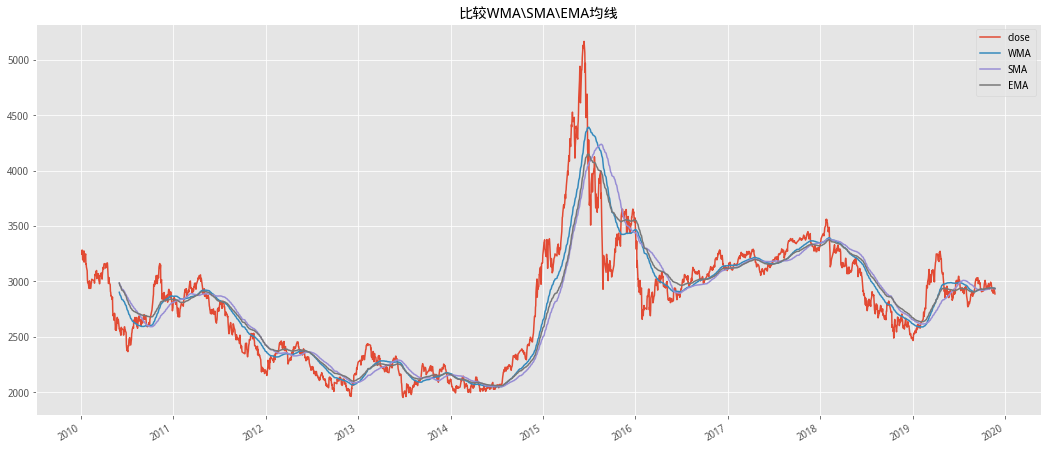

In [4]:
EMA = talib.EMA(COMPARE['close'].values, timeperiod=T)
COMPARE['EMA'] = EMA
COMPARE.plot(figsize=(18,8),title='比较WMA\SMA\EMA均线')

当 alpha = 1/T 时，得到的指数移动平均又称为**修正移动平均（Modified Moving Average，MMA）或平滑移动平均（SMoothed Moving Average，SMMA）**

无论是加权还是指数移动平均，它们都是通过对近期的数值赋予更高的权重来提高低频趋势对近期变化的敏感程度。**然而，它们的计算表达式（或算法结构）是固定的，在整个时间序列上的各个时点都使用同样的结构（即一成不变的权重分配方法）计算移动平均，而不考虑时间序列自身的特点。**

**一个优秀的移动平均算法计算出来的均线应在时间序列自身波动不明显的时点足够平滑，而在时间序列自身发生巨变时迅速捕捉、将滞后最小化。**要想达到这种效果，就必须利用时间序列自身的特点。分形自适应移动平均算法就是这样一个有力的工具。

## 分形自适应移动平均

分形自适应移动平均（FRactal Adaptive Moving Average，FRAMA）利用了投资品价格序列的分形特征。简单的说，该算法通过一个简单的公式计算从时间序列从当前时点往前2T 长度的时间窗口内的分形维数 D ，并利用分形维数进一步求解指数移动平均的参数 $\alpha$

对于当前时点 t 和给定的窗口 2T，该方法用到了三个时间窗口，即 t 到 t-T+1（记为窗口 W1，长度为 T），t-T 到 t-2T+1（记为窗口 W2，长度为 T），以及 t 到 t-2T+1（记为窗口 W，长度为 2T）。不难看出，W = W1 + W2。FRAMA 的计算过程如下：

FRAMA 的计算过程

1. 用窗口 W1 内的最高价和最低价计算 N1 = (最高价 – 最低价) / T

2. 用窗口 W2 内的最高价和最低价计算 N2 = (最高价 – 最低价) / T

3. 用窗口 W 内的最高价和最低价计算 N3 = (最高价 – 最低价) / (2T)

4. 计算分形维数 D = [log(N1+N2) – log(N3)] / log(2)

5. 计算指数移动平均的参数 alpha = exp(-4.6*(D-1))，并使其满足在 0.01 和 1 之间*

* 随着 alpha 向 1 逼近，指数平滑的衰减加剧，造成移动平均的平滑度大幅下降。因此如果将 alpha 的上限定为 1 可能带来不必要的高频扰动。在实际使用时，可以根据希望达到的最低平滑度来调整 alpha 的上限。在本文后续例子和实验中，如无特殊声明，我们将 alpha 的上限设为 0.2。

6. 将 alpha 带入EMA的公式求解 t 时刻的 FRAMA 移动平均值

$EMA=\begin{cases}
close_t,\quad t=1 \\\\
\alpha*close_t+(1-\alpha)*EMA_{t-1},\quad t>1
\end{cases}$

In [5]:
# 计算FRAMA均线
def FRAMA(se, periods, clip=True):
    
    T = int(periods/2)
    df = se.copy()

    # 1.用窗口 W1 内的最高价和最低价计算 N1 = (最高价 – 最低价) / T
    N1 = (df.rolling(T).max()-df.rolling(T).min())/T

    # 2.用窗口 W2 内的最高价和最低价计算 N2 = (最高价 – 最低价) / T
    n2_df = df.shift(T)
    N2 = (n2_df.rolling(T).max()-n2_df.rolling(T).min())/T

    # 3.用窗口 T 内的最高价和最低价计算 N3 = (最高价 – 最低价) / (2T)
    N3 = (df.rolling(periods).max() -
          df.rolling(periods).min())/periods

    # 4.计算分形维数 D = [log(N1+N2) – log(N3)] / log(2)
    D = (np.log10(N1+N2)-np.log10(N3))/np.log10(2)

    # 5.计算指数移动平均的参数 alpha = exp(-4.6(D-1))
    alpha = np.exp(-4.6*(D-1))

    # 设置上线
    if clip:
        alpha = np.clip(alpha, 0.01, 0.2)

    FRAMA = []
    idx = min(np.argwhere(~np.isnan(alpha)))-1
    for row, data in enumerate(alpha):
        if row == (idx):
            FRAMA.append(df.iloc[row])
        elif row > (idx):
            FRAMA.append(data*df.iloc[row] +
                         (1-data)*FRAMA[-1])
        else:
            FRAMA.append(np.nan)

    FRAMA_se = pd.Series(FRAMA, index=df.index)

    return FRAMA_se

下图比较了 T = 100 时指数移动平均以及分形自适应移动平均的平滑效果。很明显，由于利用了时间序列自身的分形特征，**FRAMA 均线对滞后性的提高非常明显，这意味着在价格趋势发生变化的时候它捕捉的更加及时。当然，取决于选取的参数，FRAMA 均线在一些局部可能不够平滑，它体现了一种动态的对平滑度和灵敏度的取舍。**

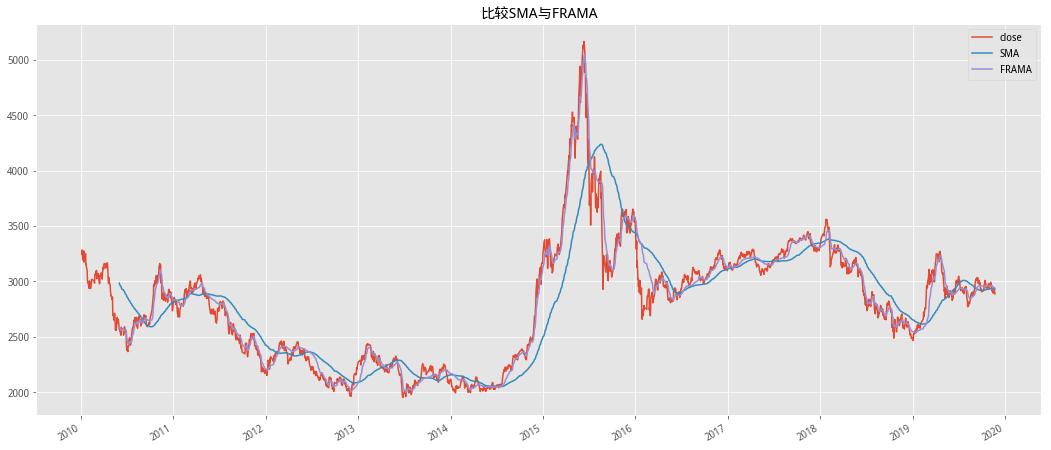

In [6]:
# FRAMA与SMA比较

FRAMA_ = FRAMA(COMPARE['close'], T, clip=True)
COMPARE['FRAMA'] = FRAMA_
COMPARE[['close', 'SMA', 'FRAMA']].plot(figsize=(18,8),title='比较SMA与FRAMA')

## 赫尔移动平均线

最后，我们再介绍一种业界常用的高级移动平均算法，即**赫尔移动平均（Hull Moving Average，HMA）**。它由 Alan Hull 发明，故由此得名。**该算法最大的特点是在减少滞后的同时有效的提高了均线的平滑程度。**

它的计算步骤。对于给定的窗口T：

1. 计算窗口为T/2的加权移动平均，并把结果乘以 2（如果T/2不是整数则取整）;
2. 计算窗口为T的加权移动平均;
3. 用第1步的结果减去第2部的结果，得到一个新的时间序列;
4. 以第 3 步得到的时间序列为对象，计算窗口为$\sqrt{T}$，的加权移动平均（如果 $\sqrt{T}$不是整数则取整）

上述数学表达式如下:
$$HMA=WMA((2*WMA(x,int(T/2))-WMA(x,T)),int(\sqrt{T})$$

最后，比较T=100时分形自适应移动平均和赫尔移动平均的平滑效果。令人惊喜的看到，**HMA均线有着不输FRAMA均线的灵敏性（滞后性非常低），并且在局部也提高了平滑性，确实做到了在保证平滑性的同时最大的降低了滞后性。**

In [7]:
# 构造HMA
def HMA(se, periods):

    close = se.values
    hma = talib.WMA(2*talib.WMA(close, int(periods/2)) -
                    talib.WMA(close, periods), int(sqrt(periods)))

    return pd.Series(hma, index=se.index)

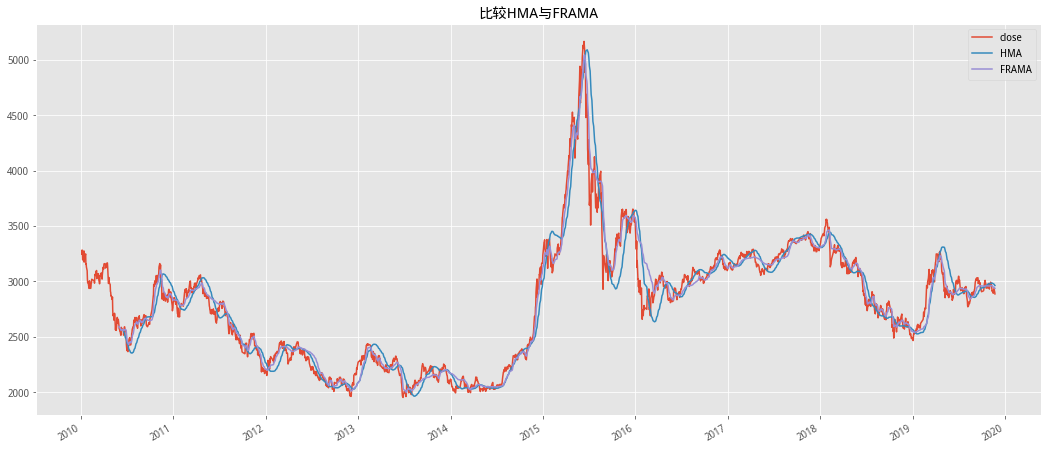

In [8]:
# 比较HMA与FRAMA
T = 100
HMA_ = HMA(COMPARE['close'], T)
COMPARE['HMA'] = HMA_
COMPARE[['close', 'HMA', 'FRAMA']].plot(figsize=(18,8),title='比较HMA与FRAMA')

# 复现部分

分为：

1.《20180410-申万宏源-均线交叉结合通道突破择时研究》

2.《20170303-广发证券-低延迟趋势线与交易择时》

以下部分为《20180410-申万宏源-均线交叉结合通道突破择时研究》的复现，均线的计算分别使用了SMA,EMA,WMA三种计算，由于原研报参数使用的是SMA，所以在EMA,WMA上效果不显著，后期可以通过敏感性测试找到合适这两个计算方法的参数;

HMA,FRAMA由于改进了均线的滞后性，一些简单的策略也能达到较好的结果，下面简单的展示一下：

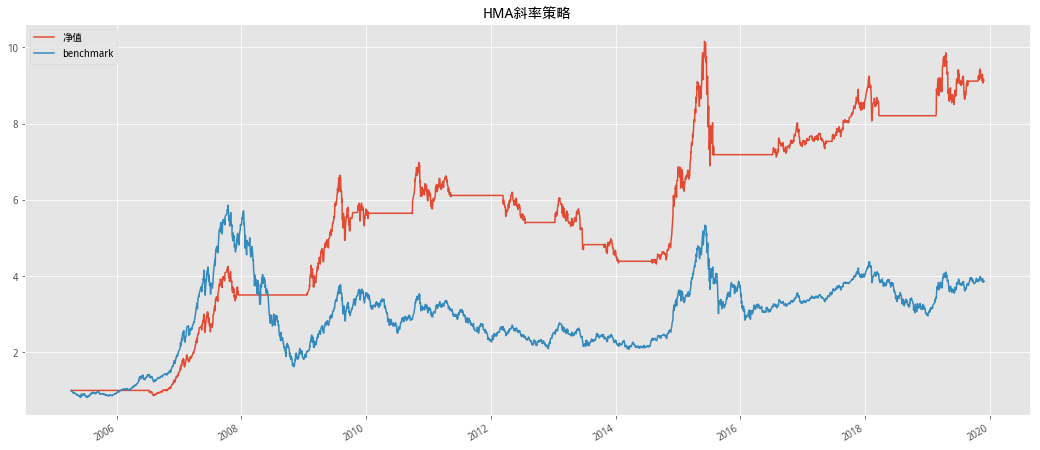

In [9]:
# 使用HMA

START = '2005-01-01'
END = '2019-11-27'
df = get_price('000300.XSHG', START, END, fields='close')

HMA_ = HMA(df['close'], 52*5)

# 均线斜率向上时开仓，否在平仓
# 计算斜率


def Cal_Slope(array_):
    return np.mean(array_[1:])/np.mean(array_[0:-1])


# 滚动计算
singal = HMA_.rolling(30).apply(Cal_Slope)
# 大于1时斜率向上
position = (singal > 1)*1.02
ret = df['close'].pct_change().shift(-1)*position
df['净值'] = (1+ret).cumprod()
df['benchmark'] = (1+df['close'].pct_change()).cumprod()
df[['净值', 'benchmark']].plot(figsize=(18,8),title='HMA斜率策略')

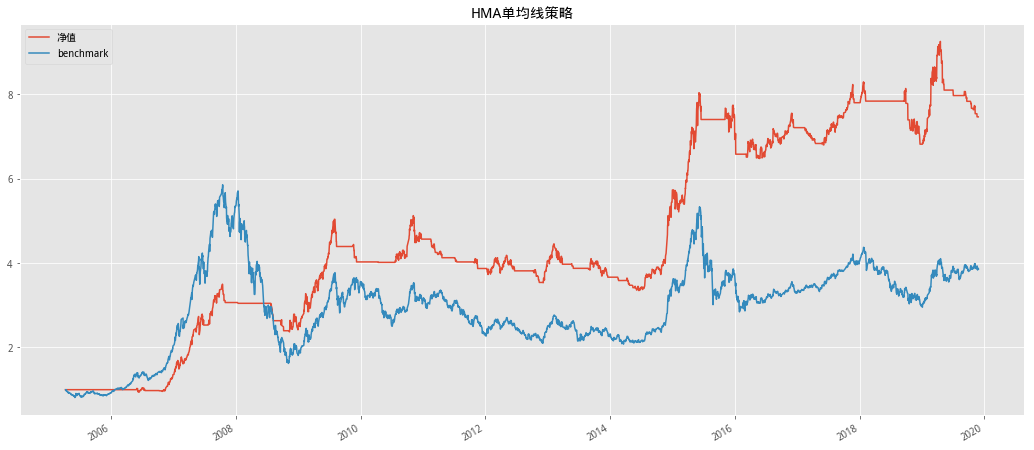

In [10]:
# 价格在均线上开仓，否则平仓
position = (df['close'] > HMA_)*1
ret = df['close'].pct_change().shift(-1)*position
df['净值'] = (1+ret).cumprod()

df['benchmark'] = (1+df['close'].pct_change()).cumprod()
df[['净值', 'benchmark']].plot(figsize=(18,8),title='HMA单均线策略')

# 均线突破交叉结合通道突破择时

择时，英文中叫做 Market Timing。顾名思义，就是在合适的市场时机进场， 在不利于投资的时机出场。择时研究，一直是一项极具诱惑力的事情。可以说解决了 择时的问题就可以一本万利，因为总可以在市场的低点买入，然后在高点卖出获利。
与之对应的，如果择时出现错误，则会造成巨大的损失。

本文中我们只考虑利用技术指标进行市场的择时,对个股判断感兴趣的读者可自行研究。研究的择时交易的标的资产是各类市场指数，比较基准是买入并持有策略（Buy and Hold）。

## 均线交叉、通道突破与动态止损

### 均线交叉策略

移动平均线（Moving Average，简称MA）是技术分析中的常用工具，被广泛 用于股票、期货、外汇等金融市场的分析中，可谓简单、有效、应用广。另一方面， 许多其他的技术指标，也建立在移动平均线的基础上。因此，移动平均线在技术分析 领域占有重要地位。

传统的均线交叉策略的思想是当快速均线上穿慢速均线时，**形成“金叉”信号，策略做多（开仓）；反之快速均线下穿慢速均线时则形成“死叉”，策略做空（平仓）**。 以沪深 300 指数为例，对传统的均线交叉策略进行回测（均线参数为(9,18),手续费按双边各 0.3%收取），我们将分布使用SMA,WMA,EMA,FRAMA均线进行回测，净值曲线如下图所示：

In [11]:
# 基础信息设置

SHORT = 9  # 短周期
LONG = 18  # 长周期
FEE = 0.003  # 手续费
INDEX_ID = '000300.XSHG'  # 标的
index_info = get_security_info(INDEX_ID)  # 指数信息

START = index_info.start_date
END = '2019-11-27'

In [12]:
# 双均线策略回测
def Double_average_strategy(INDEX_ID, START, END, SHORT, LONG, fee, method):

    DATA = get_price(INDEX_ID, START, END, fields='close')
    # 通过globals获取计算方法
    singal = Get_Double_Average_Singal(globals()[method](DATA['close'], SHORT,
                                                         LONG))  # 获取不含费
    Fee = Cal_Fee(singal, fee)  # 含费

    RET = DATA['close'].pct_change()
    Strategy_RET = RET.shift(-1)
    Strategy_Cum = (1 + Strategy_RET * singal).cumprod()
    Strategy_Fee_Cum = (1 + Strategy_RET * singal - Fee).cumprod()
    BENCHMARK = (1 + RET).cumprod()

    # 画图
    plt.figure(figsize=(18, 8))
    plt.title('策略净值图')
    plt.plot(Strategy_Cum.reindex(BENCHMARK.index), label='策略净值')
    plt.plot(Strategy_Fee_Cum.reindex(BENCHMARK.index), label='策略净值(含费用)')
    plt.plot(BENCHMARK.reindex(BENCHMARK.index), label='基准')
    plt.legend()

    # 画图
    #line1 = go.Scatter(x=BENCHMARK.index, y=Strategy_Cum, name='策略净值')
    #line2 = go.Scatter(x=BENCHMARK.index, y=Strategy_Fee_Cum, name='策略净值(含费用)')
    #line3 = go.Scatter(x=BENCHMARK.index, y=BENCHMARK, name='基准')
    #fig = go.Figure([line1, line2, line3])
    #fig.update_layout(
    #    title={'text': "策略净值图",
    #           'y': 0.9,
    #           'x': 0.5,
    #           'xanchor': 'center',
    #           'yanchor': 'top'},

    #    xaxis_title='时间',
    #    yaxis_title='净值')

    #fig.show(renderer='notebook')

    report_df = (Strategy_RET * singal).to_frame()
    report_df.columns = ['Strategy_RET']
    report_df['FEE_RET'] = (Strategy_RET * singal - Fee)
    report_df['策略净值(含费)'] = singal
    report_df['策略净值'] = singal
    # 输出回测情况
    display(
        HTML(
            summary(report_df, ['Strategy_RET', 'FEE_RET'],
                    ['策略净值', '策略净值(含费)']).to_html()))
    print('含费收益风险指标：')
    # 出分年收益
    every_y_r = report_df.groupby(pd.Grouper(level=0, freq='Y')).apply(
        Ever_year_risk, 'FEE_RET')
    display(HTML(every_y_r.to_html()))


# 单均线策略


def Single_average_strategy(INDEX_ID, START, END, LONG, fee, method):

    DATA = get_price(INDEX_ID, START, END, fields='close')
    # 通过globals获取计算方法
    singal = Get_Single_Average_Singal(globals()[method](DATA['close'], LONG,
                                                         LONG))  # 获取不含费
    Fee = Cal_Fee(singal, fee)  # 含费

    RET = DATA['close'].pct_change()  # 计算收益率
    Strategy_RET = RET.shift(-1)  # 滞后一期
    # 计算策略净值
    Strategy_Cum = (1 + Strategy_RET * singal).cumprod()  # 不含费
    Strategy_Fee_Cum = (1 + Strategy_RET * singal - Fee).cumprod()  # 含费
    # 计算基准净值
    BENCHMARK = (1 + RET).cumprod()

    # 画图
    plt.figure(figsize=(18, 8))
    plt.title('策略净值图')
    plt.plot(Strategy_Cum.reindex(BENCHMARK.index), label='策略净值')
    plt.plot(Strategy_Fee_Cum.reindex(BENCHMARK.index), label='策略净值(含费用)')
    plt.plot(BENCHMARK.reindex(BENCHMARK.index), label='基准')
    plt.legend()

    # 画图
    #line1 = go.Scatter(x=BENCHMARK.index, y=Strategy_Cum, name='策略净值')
    #line2 = go.Scatter(x=BENCHMARK.index, y=Strategy_Fee_Cum, name='策略净值(含费用)')
    #line3 = go.Scatter(x=BENCHMARK.index, y=BENCHMARK, name='基准')
    #fig = go.Figure([line1, line2, line3])
    #fig.update_layout(
    #    title={'text': "策略净值图",
    #           'y': 0.9,
    #           'x': 0.5,
    #           'xanchor': 'center',
    #           'yanchor': 'top'},
    #    xaxis_title='时间',
    #    yaxis_title='净值')
    #fig.show(renderer='notebook')

    # 构建风险报告所需格式
    report_df = (Strategy_RET * singal).to_frame()
    report_df.columns = ['Strategy_RET']
    report_df['FEE_RET'] = (Strategy_RET * singal - Fee)
    report_df['策略净值(含费)'] = singal
    report_df['策略净值'] = singal
    # 输出回测情况
    display(
        HTML(
            summary(report_df, ['Strategy_RET', 'FEE_RET'],
                    ['策略净值', '策略净值(含费)']).to_html()))
    # 出分年收益
    every_y_r = report_df.groupby(pd.Grouper(level=0, freq='Y')).apply(
        Ever_year_risk, 'FEE_RET')
    display(HTML(every_y_r.to_html()))


# =============================================
# 均线计算
# =============================================


def Cal_SMA(se, SHORT, LONG):

    s_sma = talib.SMA(se.values, SHORT)
    l_sma = talib.SMA(se.values, LONG)

    sma_df = pd.DataFrame({
        'L_MA': l_sma,
        'S_MA': s_sma,
        'CLOSE': se.values
    },
                          index=se.index)
    return sma_df


def Cal_WMA(se, SHORT, LONG):

    s_wma = talib.WMA(se.values, SHORT)
    l_wma = talib.WMA(se.values, LONG)

    wma_df = pd.DataFrame({
        'L_MA': l_wma,
        'S_MA': s_wma,
        'CLOSE': se.values
    },
                          index=se.index)
    return wma_df


def Cal_EMA(se, SHORT, LONG):

    s_ema = talib.EMA(se.values, SHORT)
    l_ema = talib.EMA(se.values, LONG)

    ema_df = pd.DataFrame({
        'L_MA': l_ema,
        'S_MA': s_ema,
        'CLOSE': se.values
    },
                          index=se.index)
    return ema_df


def Cal_FRAMA(se, SHORT, LONG):

    s_frama = FRAMA(se, SHORT)
    l_frama = FRAMA(se, LONG)

    frama_df = pd.concat([s_frama, l_frama, se], axis=1)
    frama_df.columns = ['S_MA', 'L_MA', 'CLOSE']

    return frama_df


# =============================================
# 策略
# =============================================

# 均线交叉策略 取得金叉死叉
# 通过列L_MA,S_MA名称判断长短期

'''
传入的x_df为经均线处理方法后的df index-date|column-S_MA|L_MA|CLOSE
'''


def Get_Double_Average_Singal(x_df):

    df = x_df.copy()
    # 获取昨日均线数值
    df['S_MA_PRE'] = df['S_MA'].shift(1)
    df['L_MA_PRE'] = df['L_MA'].shift(1)

    position = []  # 1为开仓0为平仓
    #
    for row, data in df.iterrows():

        s_ma = data['S_MA']
        l_ma = data['L_MA']
        s_ma_pre = data['S_MA_PRE']
        l_ma_pre = data['L_MA_PRE']

        open_s = Golden_Fork(s_ma, l_ma, s_ma_pre, l_ma_pre)
        close_s = Dead_Fork(s_ma, l_ma, s_ma_pre, l_ma_pre)

        if position:
            if open_s:
                position.append(1)
            elif close_s:
                position.append(0)
            else:
                position.append(position[-1])
        else:
            position.append(0)

    return position


# 单均线策略
'''
传入的x_df为经均线处理方法后的df index-date|column-S_MA|L_MA|CLOSE
以长周期均线为比较基准
'''


def Get_Single_Average_Singal(x_df):

    df = x_df.copy()
    # 获取昨日均线数值
    df['CLOSE_PRE'] = df['CLOSE'].shift(1)
    df['L_MA_PRE'] = df['L_MA'].shift(1)

    position = []  # 1为开仓0为平仓
    #
    for row, data in df.iterrows():

        s_ma = data['CLOSE']
        l_ma = data['L_MA']
        s_ma_pre = data['CLOSE_PRE']
        l_ma_pre = data['L_MA_PRE']

        open_s = Golden_Fork(s_ma, l_ma, s_ma_pre, l_ma_pre)
        close_s = Dead_Fork(s_ma, l_ma, s_ma_pre, l_ma_pre)

        if position:
            if open_s:
                position.append(1)
            elif close_s:
                position.append(0)
            else:
                position.append(position[-1])
        else:
            position.append(0)

    return position


# 判断金叉


def Golden_Fork(S_MA, L_MA, S_MA_PRE, L_MA_PRE):

    return S_MA > L_MA and S_MA_PRE < L_MA_PRE


# 判断死叉


def Dead_Fork(S_MA, L_MA, S_MA_PRE, L_MA_PRE):

    return S_MA < L_MA and S_MA_PRE > L_MA_PRE


# 计算双边手续费

'''
买入卖出时计算费用
'''


def Cal_Fee(singal_list, fee):

    per_s = []  # 记录昨日信号
    fee_temp = []  # 记录是否应该有费用
    for s in singal_list:
        if not per_s:
            per_s.append(0)
            fee_temp.append(0)
        else:
            if per_s[-1] == 0 and s == 1:
                per_s.append(s)
                fee_temp.append(fee)
            elif per_s[-1] == 1 and s == 0:
                fee_temp[-1] = fee
                fee_temp.append(0)
                per_s.append(s)
            else:
                per_s.append(s)
                fee_temp.append(0)

    return fee_temp


# =============================================
# 风险报告
# =============================================

# 风险报告


def summary(x_df, r_col, mark_col):
    '''
    输入收益率列表
    '''

    index_name = '年化收益率,累计收益率,夏普比率,最大回撤,持仓总天数,交易次数,平均持仓天数,获利天数, \
        亏损天数,胜率(按天),平均盈利率(按天),平均亏损率(按天),平均盈亏比(按天),盈利次数,亏损次数, \
        单次最大盈利,单次最大亏损,胜率(按此),平均盈利率(按次),平均亏损率(按次),平均盈亏比(按次)'.split(',')

    temp = []
    for r, m in zip(r_col, mark_col):

        df = pd.DataFrame(risk_report(x_df, r, m), index=index_name)
        temp.append(df)

    return pd.concat(temp, axis=1)


# 风险报告
def risk_report(x_df, r_col, mark_col):
    '''
    x_df df index-date|columns-ret|position|
    回测结果的名称以mark_col为准
    r_col：收益率
    mark_col：持仓标记点
    '''
    RET = x_df[r_col]
    summary_dic = {}

    # 格式化数据
    def format_x(x):
        return '{:.2%}'.format(x)

    # 获取回测数据
    NOT_NAN_RET = RET.dropna()
    CUM_RET = (1 + RET).cumprod()  # series

    # 计算年化收益率
    annual_ret = CUM_RET.dropna()[-1]**(250 / len(NOT_NAN_RET)) - 1

    # 计算累计收益率
    cum_ret_rate = CUM_RET.dropna()[-1] - 1

    # 最大回撤
    max_nv = np.maximum.accumulate(np.nan_to_num(CUM_RET))
    mdd = -np.min(CUM_RET / max_nv - 1)

    # 夏普
    sharpe_ratio = np.mean(NOT_NAN_RET) / \
        np.nanstd(NOT_NAN_RET, ddof=1)*np.sqrt(250)

    # 盈利次数
    temp_df = x_df[[r_col, mark_col]].copy()

    diff = temp_df[mark_col] != temp_df[mark_col].shift(1)
    temp_df[mark_col + '_diff'] = diff.cumsum()
    cond = temp_df[mark_col] == 1
    # 每次开仓的收益率情况
    temp_df = temp_df[cond].groupby(mark_col + '_diff')[r_col].sum()

    # 标记买入卖出时点
    mark = x_df[mark_col]
    pre_mark = np.nan_to_num(x_df[mark_col].shift(-1))
    # 买入时点
    trade = (mark == 1) & (pre_mark < mark)

    # 交易次数
    trade_count = len(temp_df)

    # 持仓总天数
    total = np.sum(mark)

    # 平均持仓天数
    mean_hold = total / trade_count
    # 获利天数
    win = np.sum(np.where(RET > 0, 1, 0))
    # 亏损天数
    lose = np.sum(np.where(RET < 0, 1, 0))
    # 胜率
    win_ratio = win / total
    # 平均盈利率（天）
    mean_win_ratio = np.sum(np.where(RET > 0, RET, 0)) / win
    # 平均亏损率（天）
    mean_lose_ratio = np.sum(np.where(RET < 0, RET, 0)) / lose
    # 盈亏比(天)
    win_lose = win / lose

    # 盈利次数
    win_count = np.sum(np.where(temp_df > 0, 1, 0))
    # 亏损次数
    lose_count = np.sum(np.where(temp_df < 0, 1, 0))
    # 单次最大盈利
    max_win = np.max(temp_df)
    # 单次最大亏损
    max_lose = np.min(temp_df)
    # 胜率
    win_rat = win_count / len(temp_df)
    # 平均盈利率（次）
    mean_win = np.sum(np.where(temp_df > 0, temp_df, 0)) / len(temp_df)
    # 平均亏损率（天）
    mean_lose = np.sum(np.where(temp_df < 0, temp_df, 0)) / len(temp_df)
    # 盈亏比(次)
    mean_wine_lose = win_count / lose_count

    summary_dic[mark_col] = [
        format_x(annual_ret),
        format_x(cum_ret_rate), sharpe_ratio,
        format_x(mdd), total, trade_count, mean_hold, win, lose,
        format_x(win_ratio),
        format_x(mean_win_ratio),
        format_x(mean_lose_ratio), win_lose, win_count, lose_count,
        format_x(max_win),
        format_x(max_lose),
        format_x(win_rat),
        format_x(mean_win),
        format_x(mean_lose), mean_wine_lose
    ]

    return summary_dic


# 计算每年指标
def Ever_year_risk(x_df, r_col):
    RET = x_df[r_col]

    summary_dic = {}

    # 格式化数据
    def format_x(x):
        return '{:.2%}'.format(x)

    # 获取回测数据
    NOT_NAN_RET = RET.dropna()
    CUM_RET = (1 + RET).cumprod()  # series

    # 计算年化收益率
    annual_ret = CUM_RET.dropna()[-1]**(250 / len(NOT_NAN_RET)) - 1

    # 计算累计收益率
    cum_ret_rate = CUM_RET.dropna()[-1] - 1

    # 最大回撤
    max_nv = np.maximum.accumulate(np.nan_to_num(CUM_RET))
    mdd = -np.min(CUM_RET / max_nv - 1)

    # 夏普
    sharpe_ratio = np.mean(NOT_NAN_RET) / \
        np.nanstd(NOT_NAN_RET, ddof=1)*np.sqrt(250)

    calmar_ratio = annual_ret / mdd

    return pd.Series(
        list(
            map(format_x,
                [annual_ret, cum_ret_rate, mdd, sharpe_ratio, calmar_ratio])),
        index='年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率'.split(','))


#### SMA均线

,策略净值,策略净值(含费)
年化收益率,11.78%,7.34%
累计收益率,388.49%,174.09%
夏普比率,0.674484,0.463234
最大回撤,43.51%,53.42%
持仓总天数,1960,1960
交易次数,98,98
平均持仓天数,20,20
获利天数,1092,1070
亏损天数,868,890
胜率(按天),55.71%,54.59%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,-1.34%,-0.97%,10.60%,-5.75%,-12.68%
2006-12-31,107.74%,102.34%,11.31%,362.35%,952.59%
2007-12-31,109.83%,104.91%,18.89%,246.98%,581.33%
2008-12-31,-43.07%,-42.55%,46.03%,-212.83%,-93.57%
2009-12-31,35.56%,34.58%,20.97%,135.06%,169.60%
2010-12-31,-21.86%,-21.24%,21.24%,-133.87%,-102.92%
2011-12-31,-12.40%,-12.12%,12.45%,-110.31%,-99.57%
2012-12-31,4.94%,4.80%,18.45%,41.38%,26.79%
2013-12-31,-6.25%,-5.96%,14.47%,-38.87%,-43.16%
2014-12-31,37.70%,36.82%,10.16%,197.09%,371.13%


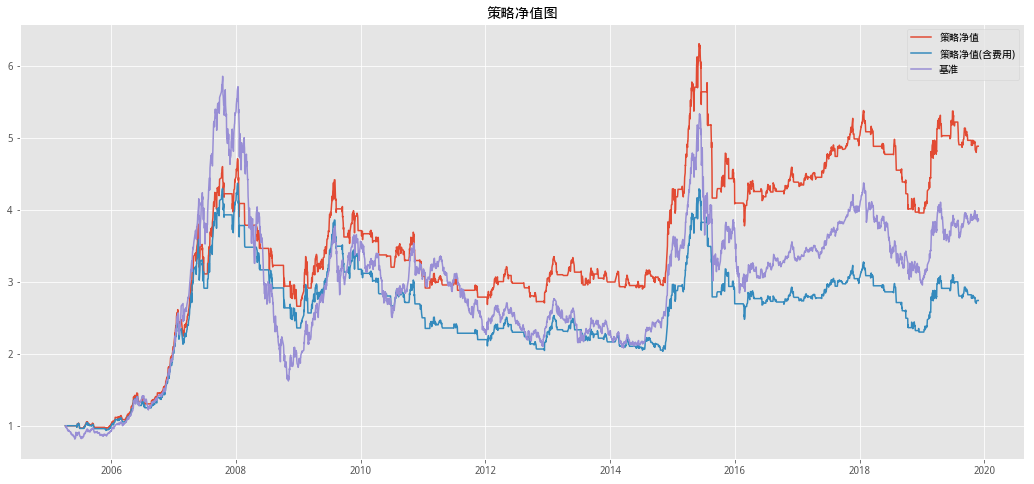

In [13]:
Double_average_strategy(INDEX_ID, START, END, SHORT, LONG, FEE, 'Cal_SMA')

#### WMA均线

,策略净值,策略净值(含费)
年化收益率,13.50%,8.50%
累计收益率,506.63%,219.42%
夏普比率,0.772825,0.527579
最大回撤,41.66%,48.42%
持仓总天数,1979,1979
交易次数,106,106
平均持仓天数,18.6698,18.6698
获利天数,1102,1077
亏损天数,877,902
胜率(按天),55.68%,54.42%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,0.63%,0.45%,8.44%,11.24%,7.43%
2006-12-31,122.60%,116.28%,8.05%,400.68%,1522.97%
2007-12-31,114.03%,108.88%,22.06%,255.30%,516.91%
2008-12-31,-39.76%,-39.27%,42.95%,-198.04%,-92.59%
2009-12-31,38.45%,37.38%,14.51%,146.38%,265.02%
2010-12-31,-13.23%,-12.83%,18.22%,-70.91%,-72.58%
2011-12-31,-6.92%,-6.76%,8.88%,-56.85%,-77.89%
2012-12-31,-0.50%,-0.49%,19.82%,3.48%,-2.52%
2013-12-31,-11.94%,-11.40%,19.83%,-77.78%,-60.21%
2014-12-31,37.81%,36.93%,11.70%,198.12%,323.18%


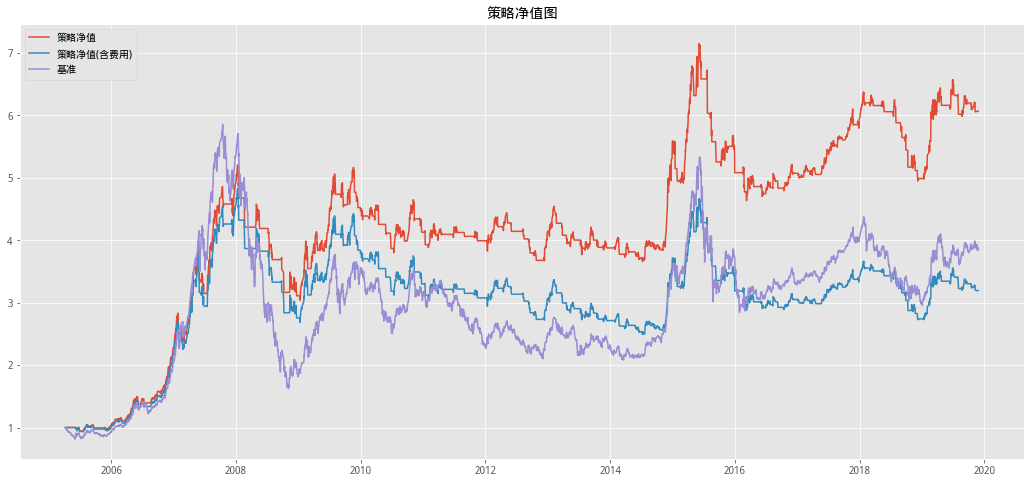

In [14]:
Double_average_strategy(INDEX_ID, START, END,SHORT, LONG,FEE, 'Cal_WMA')

#### EMA均线策略

,策略净值,策略净值(含费)
年化收益率,17.62%,14.19%
累计收益率,908.20%,561.90%
夏普比率,0.974716,0.80903
最大回撤,32.92%,36.57%
持仓总天数,1959,1959
交易次数,72,72
平均持仓天数,27.2083,27.2083
获利天数,1114,1099
亏损天数,845,860
胜率(按天),56.87%,56.10%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,3.49%,2.52%,7.73%,34.58%,45.17%
2006-12-31,107.21%,101.85%,10.24%,361.33%,1046.79%
2007-12-31,130.34%,124.28%,18.05%,272.20%,722.33%
2008-12-31,-25.13%,-24.78%,30.66%,-124.55%,-81.95%
2009-12-31,50.51%,49.04%,16.65%,172.09%,303.42%
2010-12-31,-12.89%,-12.50%,15.52%,-74.25%,-83.06%
2011-12-31,-4.16%,-4.06%,10.95%,-32.64%,-38.00%
2012-12-31,-1.07%,-1.04%,19.18%,-2.00%,-5.58%
2013-12-31,-2.00%,-1.91%,11.38%,-8.48%,-17.59%
2014-12-31,47.57%,46.43%,11.42%,240.28%,416.53%


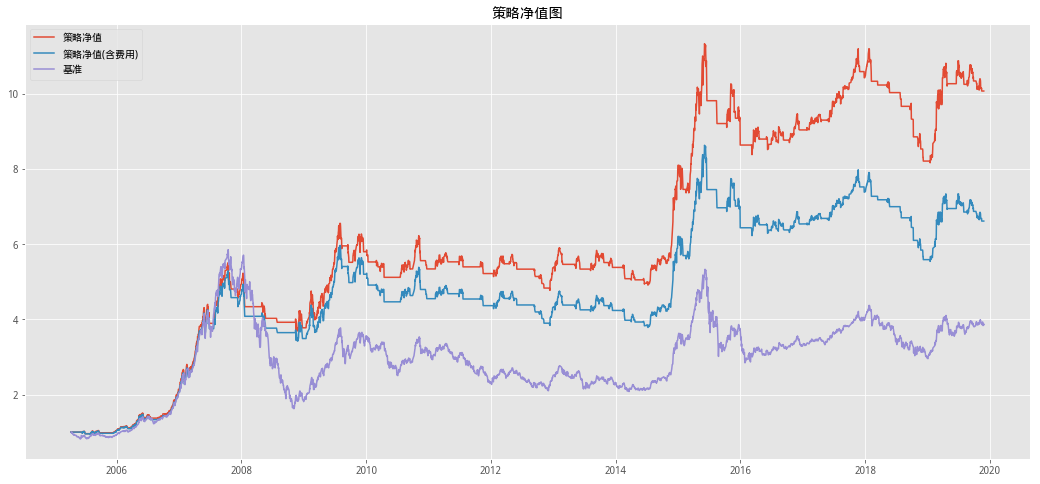

In [15]:
Double_average_strategy(INDEX_ID, START, END,SHORT, LONG,FEE, 'Cal_EMA')

从各年度上看，在沪深 300 指数下跌的年份，简单均线交叉策略跌幅均较小， 获得了一定的超额收益。在沪深 300 指数大幅下跌的 2008 年、2011 年，简单均线 交叉策略的年收益相较于指数本身明显减小了下跌幅度。而在沪深 300 指数获得正 收益的年份，简单均线交叉策略的收益都低于指数本身。 这样的结果体现了传统均线交叉策略的不稳定性。当趋势反转的时候，有可能使
策略从有效变为无效，从而造成投资者的重大损失。

## 均线交叉策略结合通道过滤（无跟踪止损）

传统的简单均线交叉系统根据均线的交叉捕捉价格变化趋势，在快速均线上穿慢 速均线（金叉）时买入，在快速均线下穿慢速均线（死叉）时卖出。<font color=DarkRed>**此类策略在市场趋势明显时较为显著。然而当市场剧烈震荡，没有明显趋势时，均线反复交叉将频繁产生信号，而其中的假信号将导致反复亏损。**</font>

<font color=DarkRed>**为了避免简单均线交叉策略在股价横盘整理时错误地判定趋势，根据假信号发出错误的交易指令，进而产生亏损，接下来在均线交叉的基础上，设置一个通道，结合通道突破对均线交叉的信号进一步过滤，静待时机，当突破了近期高点/低点形成的通道时才确定对趋势的判定。**</font>

均线交叉结合通道突破的策略充分利用快速均线和慢速均线的交叉来识别未来潜在的趋势，并在识别趋势后进行观望，设置在一定数目的 K 线内有效的通道突破价，使得交易在趋势确定后才进行，减少了因趋势迅速失效而导致的亏损。

在沪深 300 上进行均线交叉结合通道突破策略的回测(均线参数为(9,18),通道参数为 3.0)，净值曲线对照如下：

In [16]:
# 通道策略
def BollChannel(INDEX_ID, START, END, SHORT, LONG, N, fee, method):
    import plotly
    DATA = get_price(INDEX_ID, START, END, fields='close')
    # 通过globals获取计算方法
    singal = Get_BollChannel_Singal(globals()[method](DATA['close'], SHORT,
                                                      LONG), N, method)  # 获取不含费

    Fee = Cal_Fee(singal, fee)  # 含费

    RET = DATA['close'].pct_change()
    Strategy_RET = RET.shift(-1)
    Strategy_Cum = (1 + Strategy_RET * singal).cumprod()
    Strategy_Fee_Cum = (1 + Strategy_RET * singal - Fee).cumprod()
    BENCHMARK = (1 + RET).cumprod()

    # 画图
    plt.figure(figsize=(18, 8))
    plt.title('策略净值图')
    plt.plot(Strategy_Cum.reindex(BENCHMARK.index), label='策略净值')
    plt.plot(Strategy_Fee_Cum.reindex(BENCHMARK.index), label='策略净值(含费用)')
    plt.plot(BENCHMARK.reindex(BENCHMARK.index), label='基准')
    plt.legend()

    # 画图
    #line1 = go.Scatter(x=BENCHMARK.index, y=Strategy_Cum, name='策略净值')
    #line2 = go.Scatter(x=BENCHMARK.index, y=Strategy_Fee_Cum, name='策略净值(含费用)')
    #line3 = go.Scatter(x=BENCHMARK.index, y=BENCHMARK, name='基准')
    #fig = go.Figure([line1, line2, line3])

    #fig.update_layout(

    #    title={'text': "策略净值图",
    #           'y': 0.9,
    #           'x': 0.5,
    #           'xanchor': 'center',
    #           'yanchor': 'top'},

    #    xaxis_title='时间',
    #    yaxis_title='净值'),

    #fig.show(renderer='notebook')

    report_df = (Strategy_RET * singal).to_frame()
    report_df.columns = ['Strategy_RET']
    report_df['FEE_RET'] = (Strategy_RET * singal - Fee)
    report_df['策略净值(含费)'] = singal
    report_df['策略净值'] = singal

    # 输出回测情况
    display(
        HTML(
            summary(report_df, ['Strategy_RET', 'FEE_RET'],
                    ['策略净值', '策略净值(含费)']).to_html()))
    print('含费收益风险指标：')
    # 出分年收益
    every_y_r = report_df.groupby(pd.Grouper(level=0, freq='Y')).apply(
        Ever_year_risk, 'FEE_RET')
    display(HTML(every_y_r.to_html()))


# 通道策略持仓标记点


def Get_BollChannel_Singal(x_df, N, method):
    df = x_df.copy()

    # 获取昨日均线数值
    if method == 'Cal_FRAMA':
        df['S_MA'] = df['CLOSE']
        df['S_MA_PRE'] = df['CLOSE'].shift(1)
    else:
        df['S_MA_PRE'] = df['S_MA'].shift(1)

    df['L_MA_PRE'] = df['L_MA'].shift(1)
    # 近N日的高低点
    df['HIGH'] = df['CLOSE'].rolling(N).max()
    df['LOW'] = df['CLOSE'].rolling(N).min()

    # 是否金叉
    df['OPEN_S'] = df.apply(
        lambda x: Golden_Fork(x['S_MA'], x['L_MA'], x['S_MA_PRE'], x['L_MA_PRE']
                             ),
        axis=1)

    # 金叉向后近N期
    df['LAG_OPEN'] = df['OPEN_S'].rolling(N).sum()

    df['O_S'] = (df['CLOSE'] >= df['HIGH']) & df['LAG_OPEN']

    # 是否死叉
    df['CLOSE_S'] = df.apply(
        lambda x: Dead_Fork(x['S_MA'], x['L_MA'], x['S_MA_PRE'], x['L_MA_PRE']),
        axis=1)

    # 金叉向后近N期
    df['LAG_CLOSE'] = df['CLOSE_S'].rolling(N).sum()
    df['C_S'] = (df['CLOSE'] >= df['LOW']) & df['LAG_CLOSE']
    df['MARK'] = df['O_S'] * 1 + df['C_S'] * -1

    # 标记持有期
    position = []
    s = 0
    for row, data in df.iterrows():
        if data['MARK'] == -1:
            position.append(s)
            s = 0
        elif data['MARK'] == 1:
            s = 1
            position.append(s)
        else:
            position.append(s)

    df['POSITION'] = position
    return df['POSITION'].values.tolist()

#### SMA均线

,策略净值,策略净值(含费)
年化收益率,8.88%,5.62%
累计收益率,235.71%,117.95%
夏普比率,0.565067,0.39574
最大回撤,46.76%,53.92%
持仓总天数,1688,1688
交易次数,72,72
平均持仓天数,23.4444,23.4444
获利天数,946,923
亏损天数,742,765
胜率(按天),56.04%,54.68%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,3.17%,2.29%,10.30%,38.24%,30.82%
2006-12-31,105.34%,100.09%,12.76%,359.24%,825.57%
2007-12-31,47.61%,45.78%,20.15%,157.78%,236.32%
2008-12-31,-25.73%,-25.38%,29.89%,-118.91%,-86.09%
2009-12-31,30.29%,29.46%,23.19%,118.54%,130.58%
2010-12-31,-10.23%,-9.92%,18.82%,-58.06%,-54.35%
2011-12-31,-8.14%,-7.95%,13.71%,-78.32%,-59.38%
2012-12-31,-1.64%,-1.60%,5.58%,-32.36%,-29.41%
2013-12-31,-9.52%,-9.09%,15.32%,-84.81%,-62.14%
2014-12-31,36.70%,35.85%,8.49%,201.64%,432.25%


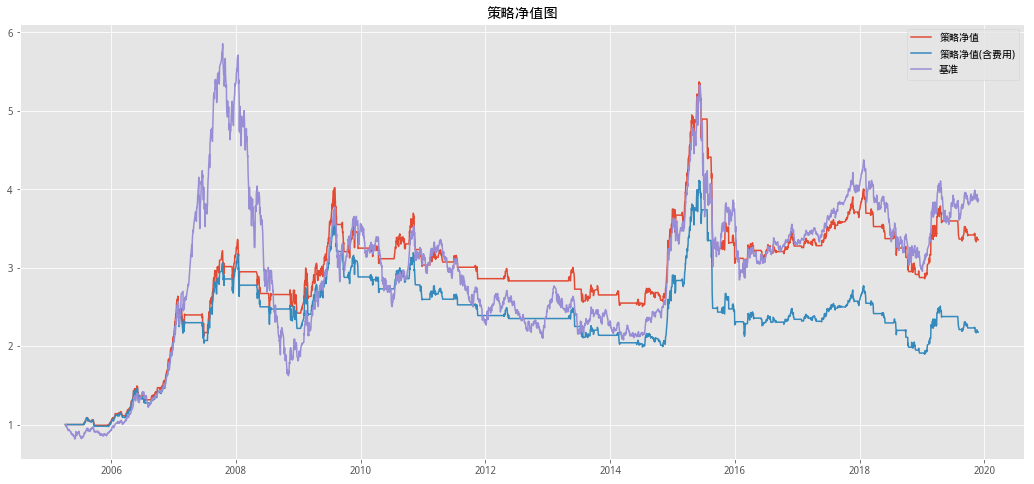

In [17]:
BollChannel(INDEX_ID, START, END, SHORT, LONG, 3, FEE, 'Cal_SMA')

#### WMA均线

,策略净值,策略净值(含费)
年化收益率,15.45%,11.67%
累计收益率,673.96%,381.69%
夏普比率,0.874534,0.692939
最大回撤,40.98%,43.33%
持仓总天数,1777,1777
交易次数,79,79
平均持仓天数,22.4937,22.4937
获利天数,1020,992
亏损天数,757,785
胜率(按天),57.40%,55.82%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,-0.87%,-0.63%,9.25%,-0.66%,-9.36%
2006-12-31,121.53%,115.27%,7.79%,398.89%,1559.10%
2007-12-31,123.45%,117.77%,21.27%,267.23%,580.48%
2008-12-31,-38.54%,-38.06%,42.39%,-183.03%,-90.92%
2009-12-31,38.73%,37.64%,13.48%,145.00%,287.20%
2010-12-31,-12.79%,-12.40%,17.36%,-92.57%,-73.63%
2011-12-31,-6.18%,-6.03%,7.77%,-54.00%,-79.45%
2012-12-31,2.59%,2.52%,18.61%,25.20%,13.92%
2013-12-31,-6.25%,-5.96%,14.48%,-46.88%,-43.17%
2014-12-31,38.75%,37.84%,10.91%,209.76%,355.25%


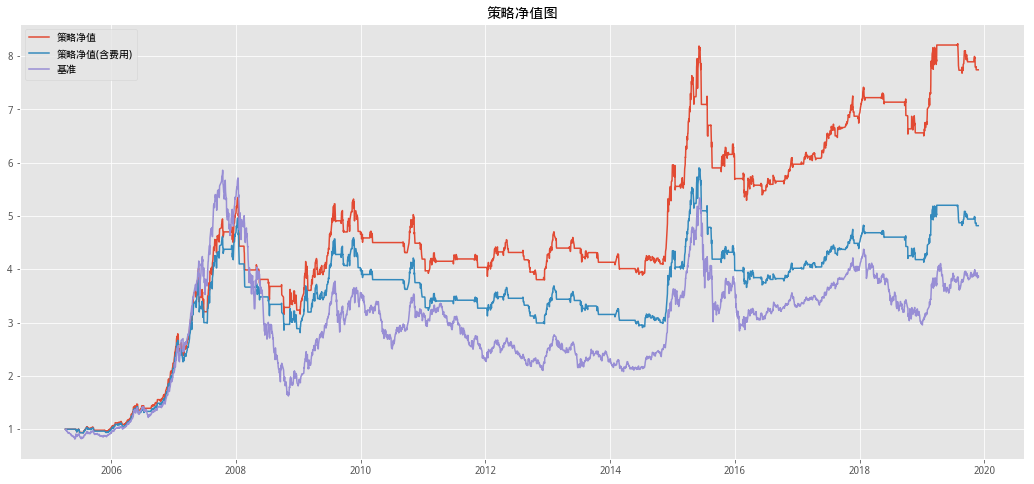

In [18]:
BollChannel(INDEX_ID, START, END, SHORT, LONG, 3, FEE, 'Cal_WMA')

#### EMA均线

,策略净值,策略净值(含费)
年化收益率,19.82%,16.97%
累计收益率,1212.77%,831.81%
夏普比率,1.07376,0.941685
最大回撤,32.54%,34.53%
持仓总天数,1907,1907
交易次数,57,57
平均持仓天数,33.4561,33.4561
获利天数,1103,1081
亏损天数,804,826
胜率(按天),57.84%,56.69%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,11.04%,7.88%,5.93%,112.63%,186.37%
2006-12-31,109.86%,104.33%,9.55%,368.89%,1150.41%
2007-12-31,122.06%,116.46%,19.50%,259.69%,626.08%
2008-12-31,-21.91%,-21.60%,27.40%,-102.09%,-79.98%
2009-12-31,60.31%,58.51%,18.67%,193.64%,322.97%
2010-12-31,-8.52%,-8.25%,12.80%,-47.83%,-66.53%
2011-12-31,-6.04%,-5.90%,12.66%,-52.01%,-47.76%
2012-12-31,8.15%,7.92%,11.74%,71.10%,69.44%
2013-12-31,-1.51%,-1.44%,13.48%,-4.85%,-11.18%
2014-12-31,44.74%,43.67%,12.90%,228.21%,346.91%


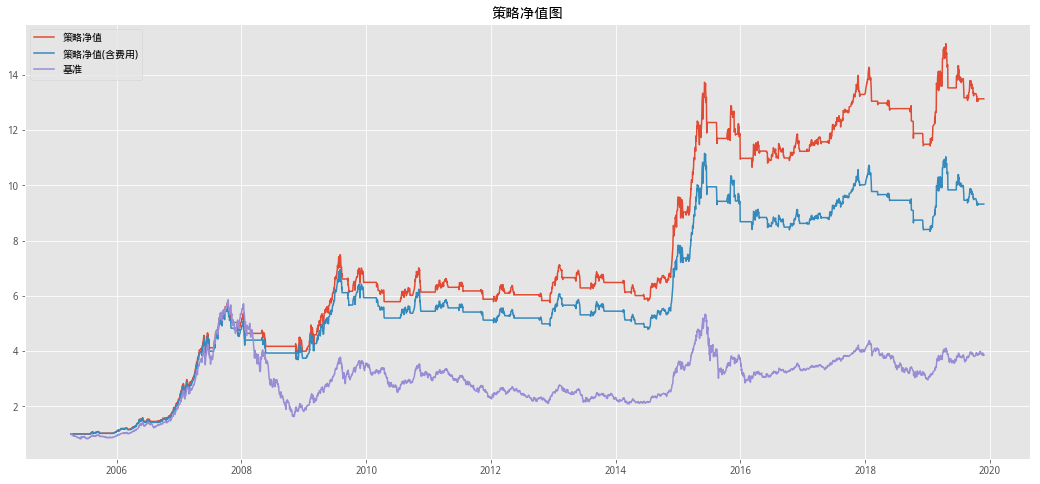

In [19]:
BollChannel(INDEX_ID, START, END, SHORT, LONG, 3, FEE, 'Cal_EMA')

## 均线交叉结合通道突破和动态止损策略构建详述

在快速均线（FastWindow 个交易日的均线）上穿慢速均线（SlowWindow 个 交易日的均线）时（<font color=Crimso>**金叉**</font>），认为价格有上涨趋势，设置买入触发价为最近ChLen个交易日的<font color=Crimso>**日内最高价的最高者**</font>。快速均线下穿慢速均线时（<font color=Crimso>**死叉**</font>），认为价格有下跌趋势，设置卖出触发价为最近ChLen个交易日的<font color=Crimso>**日内最低价的最低者**</font>。<u>出现均线交叉信号后的**ChLen个交易日内**，若价格向上突破阻力位时发出买入信号，价格向下突破支撑位时发出卖出信号，反手出场。出现均线交叉信号的**ChLen个交易日之后**此信号失效。</u>
    
<font color=DarkRed>**持仓时设置跟踪止损触发价为 TrailWindow 个交易日的日内最低价的最低者。价格跌破该触发价时进行止损，暂时出场。在出场后，设置阻力线为最近 ReEntryChLen 个交易日内最高价的高点。若在出场后的ReEntryWindow个交易日内价格向上突破此阻力线，判定原趋势继续,再度进场。出场ReEntryWindow个交易日之后此信号失效。**</font>
    
多空策略互不干扰，同时采用多空策略交易时，趋势出现反转时先进行平仓再反向建仓。本文中以下若无特别说明，所提及的“本策略”皆指均线交叉结合通道突破的多头策略。

**PS:日内最高或最低价**

## 均线交叉结合通道突破策略涉及的技术指标

本策略主要涉及快速均线、慢速均线、通道突破、跟踪止损。 快速均线上穿慢速均线（金叉）意味着短期上涨趋势，快速均线下穿慢速均线（死
叉）意味着短期下跌趋势。 

在识别趋势后设置进出场突破通道，价格向上突破阻力线时发出买入信号，价格向下突破支撑位时发出卖出信号。 

持仓时采用移动窗口，将近期日内最低价的最低者作为跟踪止损触发价，价格跌破此支撑位时进行跟踪止损。出场后可能出现趋势继续，需要重新进场。将<font color=Crimso>**出场后的日内最高价的最高者作为再进场买入突破价**</font>。当价格向上突破该买入触发价时再次进场。

## 均线交叉结合通道突破策略参数设置

由于本策略涉及的参数较多，为了减少后期优化参数过程中由于参数过多而产生 过拟合，对移动均线窗口、通道突破周期、再进场周期等相关参数采取关联处理。使得相互独立参数的个数减少到 2 个，显著提升了优化的效率。

|参数|参数含义|参数关联|规则|
|--|--|--|--|
|FastWindow|快速均线窗口长度|||
|SlowWindow|慢速均线窗口长度|2*FastWindow||
|ChLen|通道突破周期|FastWindow+3|识别趋势后ChLen跟K线内突破才发出交易指令|
|ExtraPct|通道突破幅度||买入突破价=出现金叉时的价格*（1+通道突破幅度);卖出突破价=死叉价格*（1-通道突破幅度)|
|TrailWindow|跟踪止损窗口长度|FastWindow-1||持多头仓时，将最近TrailWindow根K线的最低价作为跟择止损价;持多头时,将最近TrailWindow根K线的最高价作为跟择报价|
|ReEntryWindow|出场到再度进场的最大间隔|2*FastWindow-3|再进场指令仅再出场后的ReEntryWindow根K线内有效|
|ReEntryChLen|再进场通道突破周期|FastWindow+1|多头出场时记录最近ReEntryChLen根K线的高点作为再进场突破价;空头出场时记录最近ReEntryChLen根K线的低点作为再进场突破价|

## 均线交叉结合通道突破策略择时初步效果

默认参数：
1. 快速均线窗口长度 FastWindow = 9
2. 通道突破幅度 ExtraPct = 3.0。 
3. 相关联的默认参数：慢速均线窗口长度 SlowWindow = 2 * FastWindow =18，
4. 通道突破周期 ChLen = FastWindow + 3 = 12，
5. 跟踪止损窗口长度 TrailWindow = FastWindow – 1 = 8 ， 
6. 出场到再度进场的最大间隔 ReEntryWindow = 2 * FastWindow – 3 = 15 ，
7. 再进场通道突破周期ReEntryChLen = FastWindow + 1 = 10。

In [20]:
# 费率及标的设置
FEE = 0.003  # 手续费
INDEX_ID = '000300.XSHG'  # 标的
index_info = get_security_info(INDEX_ID) # 指数信息

START = index_info.start_date
END = '2019-12-03'

# 参数设置
FastWindow = 9 # 短周期
ExtraPct = 0.03 # 突破比率
SlowWindow = 2*FastWindow # 长周期
ChLen = FastWindow+3 # 买入/卖出观察窗口
TrailWindow = FastWindow-1 # 跟踪止损窗口长度
ReEntryWindow = 2*FastWindow # 出场到再度进场的最大间隔
ReEntryChLen = FastWindow+1 # 再进场通道突破周期

## 均线交叉结合通道突破策略择时回测模块

In [21]:
class Back_Testing(object):

    def __init__(self, INDEX_ID, START, END, FEE, FastWindow, SlowWindow,
                 ExtraPct, ChLen, TrailWindow, ReEntryWindow, ReEntryChLen,
                 Cal_Method, Strategy_Method):

        self.INDEX_ID = INDEX_ID  # 标的
        self.START = START  # 起始日
        self.END = END  # 结束日
        self.FEE = FEE  # 手续费
        self.FastWindow = FastWindow  # 短周期
        self.SlowWindow = SlowWindow  # 长周期
        self.ExtraPct = ExtraPct  # 突破比率
        self.ChLen = ChLen  # 买入/卖出观察窗口
        self.TrailWindow = TrailWindow  # 跟踪止损窗口长度
        self.ReEntryWindow = ReEntryWindow  # 出场到再度进场的最大间隔
        self.ReEntryChLen = ReEntryChLen  # 再进场通道突破周期
        self.INDEX_INFO = get_security_info(INDEX_ID)  # 指数信息
        self.Cal_Method = Cal_Method  # 均线计算的方法
        self.Strategy_Method = Strategy_Method  # 策略方法：单均线或者双均线

    # 获取数据
    @property
    def Get_Data(self):

        # 数据预准备
        begin_step = max(self.ReEntryChLen, self.ReEntryWindow,
                         self.TrailWindow, self.ChLen)
        # 获取前序数据日期
        begin = get_trade_days(end_date=self.START, count=begin_step)[0]

        return get_price(
            self.INDEX_ID,
            start_date=begin,
            end_date=self.END,
            fields='close,open,high,low'.split(','))

    # =============================================
    # 均线计算
    # =============================================

    def Cal_SMA(self, se, timeperiod):

        s_sma = talib.SMA(se.values, timeperiod)

        sma_df = pd.DataFrame({'MA': s_sma}, index=se.index)
        return sma_df

    def Cal_WMA(self, se, timeperiod):

        s_wma = talib.WMA(se.values, timeperiod)

        wma_df = pd.DataFrame({'MA': s_wma}, index=se.index)
        return wma_df

    def Cal_EMA(self, se, timeperiod):

        s_ema = talib.EMA(se.values, timeperiod)

        ema_df = pd.DataFrame({'MA': s_ema}, index=se.index)
        return ema_df

    def Cal_FRAMA(self, se, timeperiod):

        T = int(timeperiod / 2)
        df = se.copy()
        frama_temp = []  # 储存中间过程
        # 1.用窗口 W1 内的最高价和最低价计算 N1 = (最高价 – 最低价) / T
        N1 = (df.rolling(T).max() - df.rolling(T).min()) / T

        # 2.用窗口 W2 内的最高价和最低价计算 N2 = (最高价 – 最低价) / T
        n2_df = df.shift(T)
        N2 = (n2_df.rolling(T).max() - n2_df.rolling(T).min()) / T

        # 3.用窗口 T 内的最高价和最低价计算 N3 = (最高价 – 最低价) / (2T)
        N3 = (df.rolling(timeperiod).max() -
              df.rolling(timeperiod).min()) / timeperiod

        # 4.计算分形维数 D = [log(N1+N2) – log(N3)] / log(2)
        D = (np.log10(N1 + N2) - np.log10(N3)) / np.log10(2)

        # 5.计算指数移动平均的参数 alpha = exp(-4.6(D-1))
        alpha = np.exp(-4.6 * (D - 1))

        # 设置上线
        if clip:
            alpha = np.clip(alpha, 0.01, 0.2)

        idx = min(np.argwhere(~np.isnan(alpha))) - 1

        for row, data in enumerate(alpha):

            if row == (idx):

                frama_temp.append(df.iloc[row])

            elif row > (idx):

                value = data * df.iloc[row] + (1 - data) * frama_temp[-1]
                frama_temp.append(value)
            else:
                frama_temp.append(np.nan)

        FRAMA_se = pd.DataFrame(frama_temp, columns=['MA'], index=df.index)

        return FRAMA_se

    @property
    def _Cal_Func(self):

        Method_dic = dict(
            zip('Cal_SMA,Cal_WMA,Cal_EMA,Cal_FRAMA'.split(','),
                [self.Cal_SMA, self.Cal_WMA, self.Cal_EMA, self.Cal_FRAMA]))

        df = self.Get_Data  # 获取数据

        if self.Strategy_Method == 'Double_Average':
            S_MA = Method_dic[self.Cal_Method](df['close'],
                                               self.FastWindow)  # 计算短周期
            L_MA = Method_dic[self.Cal_Method](df['close'],
                                               self.SlowWindow)  # 计算长周期
        elif self.Strategy_Method == 'Single_Average':
            S_MA = df['close']  # 收盘价为短周期
            L_MA = Method_dic[self.Cal_Method](df['close'],
                                               self.SlowWindow)['MA']  # 计算长周期

        df['COMPAR'] = S_MA - L_MA  # 当前日
        df['PER_COMPAR'] = df['COMPAR'].shift(1)  # 昨日

        # 标记金叉
        df['GOLDEN_FORK'] = (df['COMPAR'] > 0) & (df['PER_COMPAR'] < 0)
        # 标记死叉
        df['DEAD_FORK'] = (df['COMPAR'] < 0) & (df['PER_COMPAR'] > 0)

        return df

    # ==========================================================
    #   回测用
    # ==========================================================

    # 买入突破价 出现金叉信号时的价格 *（1 + 通道突破幅度）
    def Get_ChLen_Buy(self, Fork_Table, ChLen, ExtraPct):
        '''
        如果ChLen窗口内有金叉则有数字否在为np.nan
        '''
        # 获取金叉价
        try:
            Golden_Fork_Close = Fork_Table.iloc[-ChLen:].query(
                'GOLDEN_FORK == True')['close'].iloc[-1]
        except IndexError:
            Golden_Fork_Close = np.nan  # close>np.nan return False

        # print('Golden_Fork_Close:%s'%Golden_Fork_Close)
        # 获取突破价
        ChLen_Close_Buy = Golden_Fork_Close * (1 + ExtraPct)

        return ChLen_Close_Buy

    # 卖出突破价  出现死叉信号时的价格 *（1 - 通道突破幅度）
    def Get_ChLen_Sell(self, Fork_Table, ChLen, ExtraPct):
        '''
        如果ChLen窗口内有死叉则有数字否在为np.nan
        '''
        # 获取死叉价
        try:
            Dead_Fork_Close = Fork_Table.iloc[-ChLen:].query(
                'DEAD_FORK==True')['close'].iloc[-1]
        except IndexError:
            Dead_Fork_Close = np.nan  # close>np.nan return False

        # print('Dead_Fork_Close:%s'%Dead_Fork_Close)
        # 获取突破价
        ChLen_Close_Sell = Dead_Fork_Close * (1 - ExtraPct)

        return ChLen_Close_Sell

    # 获取跟踪止损价
    def Get_Trail(self, Fork_Table, TrailWindow):
        Trail_df = Fork_Table['low'].rolling(TrailWindow).min()
        return Trail_df.iloc[-1]

    # 检查持仓是否是否跌破止损价
    def Check_Holding(self, Fork_Table, info_date, Trail_Close, ReEntryChLen):

        # nonlocal ReEntry_day
        # nonlocal ReEntryChLen_close
        # nonlocal info_date

        last_price = Fork_Table['open,low,high,close'.split(',')].iloc[-1].max()
        # 跌破止损
        if last_price < Trail_Close:

            self.log_text.append('%s,现价:%s小于Trail_Close:%s,卖出'.format(
                info_date, last_price, Trail_Close))
            # 卖出
            self.portfolio.append(0)

            # 记录近ReEntryChLen的最高价作为再入场突破价
            ReEntryChLen_close = Fork_Table['high'].rolling(ReEntryChLen).max()
            self.ReEntryChLen_close = ReEntryChLen_close.iloc[-1]
            self.log_text.append('%s,确定ReEntryChLen_close:%s'.format(
                info_date, ReEntryChLen_close))
            self.ReEntry_day = 1
        else:
            self.portfolio.append(self.portfolio[-1])

    # 主回测函数
    @property
    def Get_Position(self):

        index_df = self._Cal_Func
        # 循环设置
        start_step = max(self.ReEntryChLen, self.ReEntryWindow,
                         self.TrailWindow, self.ChLen)
        end_step = len(index_df)

        self.portfolio = [0] * (start_step - 1)  # 持仓
        self.ReEntry_day = 0  # 初始化再进入窗口
        self.ReEntryChLen_close = np.nan

        self.log_text = []  # 交易日志

        # 导入数据
        for i in range(start_step, end_step + 1):

            ########################################
            #      初始设置
            ########################################
            slice_data = index_df.iloc[i - start_step:i]
            info_date = slice_data.index[-1].strftime('%Y-%m-%d')

            # 判断ChLen窗口期内是否有金叉
            is_golden = slice_data['GOLDEN_FORK'].iloc[-self.ChLen:].sum() >= 1
            # 判断ChLen窗口期内是否死叉金叉
            is_dead = slice_data['DEAD_FORK'].iloc[-self.ChLen:].sum() >= 1
            # 记录昨日的信息 故iloc[:-1]
            # 买入突破价
            ChLen_Buy = self.Get_ChLen_Buy(slice_data.iloc[:-1], self.ChLen,
                                           self.ExtraPct)
            # 卖出突破价
            ChLen_Sell = self.Get_ChLen_Sell(slice_data.iloc[:-1], self.ChLen,
                                             self.ExtraPct)
            # 跟踪止损价
            Trail_Close = self.Get_Trail(slice_data.iloc[:-1], self.TrailWindow)

            # 判断是否有持仓

            if self.portfolio[-1] == 1:
                # 有持仓
                # 有死叉并触发卖出突破价
                last_price = slice_data['open,low,high,close'.split(
                    ',')].iloc[-1].max()
                if is_dead and last_price < ChLen_Sell:
                    self.log_text.append('%s,有死叉并触发卖出突破价'.format(info_date))
                    self.portfolio.append(0)  # 卖出
                else:
                    # 今日持仓检查
                    self.Check_Holding(slice_data, info_date, Trail_Close,
                                       self.ReEntryChLen)
            else:

                # 无持仓
                last_price = slice_data['open,low,high,close'.split(
                    ',')].iloc[-1].min()
                # 前ChLen日有金叉，突破通道价
                if is_golden and last_price >= ChLen_Buy:
                    self.log_text.append('%s,开仓买入,现价:%s,ChLen_Close:%s'.format(
                        info_date, last_price, ChLen_Buy))

                    self.portfolio.append(1)  # 买入

                # 有跟踪买入信号
                elif self.ReEntry_day > 0 and self.ReEntry_day < self.ReEntryWindow:
                    # 大于再买入突破价
                    if last_price > self.ReEntryChLen_close:

                        self.log_text.append('%s,突破再买入价；现价:%s,在买入价:%s'.format(
                            info_date, last_price, self.ReEntryChLen_close))

                        self.portfolio.append(1)  # 买入
                        self.ReEntry_day = 0

                    # 不满足再入场
                    else:
                        self.portfolio.append(self.portfolio[-1])
                        self.ReEntry_day += 1
                else:

                    self.portfolio.append(self.portfolio[-1])
                    self.ReEntry_day = 0

        return index_df, self.portfolio, self.log_text

    # 计算双边手续费
    '''
    买入卖出时计算费用
    '''

    def Cal_Fee(self, singal_list, fee):

        per_s = []  # 记录昨日信号
        fee_temp = []  # 记录是否应该有费用
        for s in singal_list:
            if not per_s:
                per_s.append(0)
                fee_temp.append(0)
            else:
                if per_s[-1] == 0 and s == 1:
                    per_s.append(s)
                    fee_temp.append(fee)
                elif per_s[-1] == 1 and s == 0:
                    fee_temp[-1] = fee
                    fee_temp.append(0)
                    per_s.append(s)
                else:
                    per_s.append(s)
                    fee_temp.append(0)

        return fee_temp

    # =============================================================
    #  回测报告
    # =============================================================
    def Summary(self, is_plot=True):

        index_df, portfolio, log_text = self.Get_Position
        begin_step = max(self.ReEntryChLen, self.ReEntryWindow,
                         self.TrailWindow, self.ChLen)

        df = index_df[['close']].copy()

        df['策略收益'] = portfolio
        df['策略收益(含费)'] = portfolio

        Fee = self.Cal_Fee(portfolio, self.FEE)  # 含费
        df['RET'] = df['close'].pct_change()

        df = df.iloc[begin_step:]
        Fee = Fee[begin_step:]

        df['策略收益率'] = df['RET'].shift(-1) * df['策略收益']
        df['策略净值'] = (1 + df['策略收益率']).cumprod()

        df['策略收益率(含费)'] = df['RET'].shift(-1) * df['策略收益'] - Fee
        df['策略净值(含费)'] = (1 + df['策略收益率(含费)']).cumprod()

        df['BENCHMARK'] = (1 + df['RET']).cumprod()

        if is_plot:
            # 画图
            col = '策略净值,策略净值(含费),BENCHMARK'.split(',')
            self.Plot_Nev(df, col)

            display(
                HTML(
                    self.summary(df, ['策略收益率', '策略收益率(含费)'],
                                 ['策略收益', '策略收益(含费)']).to_html()))

            print('含费收益风险指标：')

            # 出分年收益
            every_y_r = df.groupby(pd.Grouper(level=0, freq='Y')).apply(
                self.Ever_year_risk, '策略收益率(含费)')
            display(HTML(every_y_r.to_html()))
        else:
            # 只输出报告
            return self.summary(df, ['策略收益率', '策略收益率(含费)'],
                                ['策略收益', '策略收益(含费)'])

    # 画净值
    def Plot_Nev(self, df, col):

        #pio.renderers.default = "notebook"
        #df[col].iplot(title='策略净值', legend='top')
        df[col].plot(figsize=(18, 8), title='策略净值')

    # 报告汇总
    def summary(self, x_df, r_col, mark_col):
        '''
        输入收益率列表
        '''

        index_name = '年化收益率,累计收益率,夏普比率,最大回撤,持仓总天数,交易次数,平均持仓天数,获利天数, \
            亏损天数,胜率(按天),平均盈利率(按天),平均亏损率(按天),平均盈亏比(按天),盈利次数,亏损次数, \
            单次最大盈利,单次最大亏损,胜率(按此),平均盈利率(按次),平均亏损率(按次),平均盈亏比(按次)'.split(',')

        temp = []
        for r, m in zip(r_col, mark_col):

            df = pd.DataFrame(self.risk_report(x_df, r, m), index=index_name)
            temp.append(df)

        return pd.concat(temp, axis=1)

    # 风险报告
    def risk_report(self, x_df, r_col, mark_col):
        '''
        x_df df index-date|columns-ret|position|
        回测结果的名称以mark_col为准
        r_col：收益率
        mark_col：持仓标记点
        '''

        RET = x_df[r_col]
        summary_dic = {}

        # 格式化数据
        def format_x(x):
            return '{:.2%}'.format(x)

        # 获取回测数据
        NOT_NAN_RET = RET.dropna()
        CUM_RET = (1 + RET).cumprod()  # series

        # 计算年化收益率
        annual_ret = CUM_RET.dropna()[-1]**(250 / len(NOT_NAN_RET)) - 1

        # 计算累计收益率
        cum_ret_rate = CUM_RET.dropna()[-1] - 1

        # 最大回撤
        max_nv = np.maximum.accumulate(np.nan_to_num(CUM_RET))
        mdd = -np.min(CUM_RET / max_nv - 1)

        # 夏普
        sharpe_ratio = np.mean(NOT_NAN_RET) / \
            np.nanstd(NOT_NAN_RET, ddof=1)*np.sqrt(250)

        # 盈利次数
        temp_df = x_df[[r_col, mark_col]].copy()

        diff = temp_df[mark_col] != temp_df[mark_col].shift(1)
        temp_df[mark_col + '_diff'] = diff.cumsum()
        cond = temp_df[mark_col] == 1
        # 每次开仓的收益率情况
        temp_df = temp_df[cond].groupby(mark_col + '_diff')[r_col].sum()

        # 标记买入卖出时点
        mark = x_df[mark_col]
        pre_mark = np.nan_to_num(x_df[mark_col].shift(-1))
        # 买入时点
        trade = (mark == 1) & (pre_mark < mark)

        # 交易次数
        trade_count = len(temp_df)

        # 持仓总天数
        total = np.sum(mark)

        # 平均持仓天数
        mean_hold = total / trade_count
        # 获利天数
        win = np.sum(np.where(RET > 0, 1, 0))
        # 亏损天数
        lose = np.sum(np.where(RET < 0, 1, 0))
        # 胜率
        win_ratio = win / total
        # 平均盈利率（天）
        mean_win_ratio = np.sum(np.where(RET > 0, RET, 0)) / win
        # 平均亏损率（天）
        mean_lose_ratio = np.sum(np.where(RET < 0, RET, 0)) / lose
        # 盈亏比(天)
        win_lose = win / lose

        # 盈利次数
        win_count = np.sum(np.where(temp_df > 0, 1, 0))
        # 亏损次数
        lose_count = np.sum(np.where(temp_df < 0, 1, 0))
        # 单次最大盈利
        max_win = np.max(temp_df)
        # 单次最大亏损
        max_lose = np.min(temp_df)
        # 胜率
        win_rat = win_count / len(temp_df)
        # 平均盈利率（次）
        mean_win = np.sum(np.where(temp_df > 0, temp_df, 0)) / len(temp_df)
        # 平均亏损率（天）
        mean_lose = np.sum(np.where(temp_df < 0, temp_df, 0)) / len(temp_df)
        # 盈亏比(次)
        mean_wine_lose = win_count / lose_count

        summary_dic[mark_col] = [
            format_x(annual_ret),
            format_x(cum_ret_rate), sharpe_ratio,
            format_x(mdd), total, trade_count, mean_hold, win, lose,
            format_x(win_ratio),
            format_x(mean_win_ratio),
            format_x(mean_lose_ratio), win_lose, win_count, lose_count,
            format_x(max_win),
            format_x(max_lose),
            format_x(win_rat),
            format_x(mean_win),
            format_x(mean_lose), mean_wine_lose
        ]

        return summary_dic

    # 计算每年指标
    def Ever_year_risk(self, x_df, ret_col):
        RET = x_df[ret_col]

        summary_dic = {}

        # 格式化数据
        def format_x(x):
            return '{:.2%}'.format(x)

        # 获取回测数据
        NOT_NAN_RET = RET.dropna()
        CUM_RET = (1 + RET).cumprod()  # series

        # 计算年化收益率
        annual_ret = CUM_RET.dropna()[-1]**(250 / len(NOT_NAN_RET)) - 1

        # 计算累计收益率
        cum_ret_rate = CUM_RET.dropna()[-1] - 1

        # 最大回撤
        max_nv = np.maximum.accumulate(np.nan_to_num(CUM_RET))
        mdd = -np.min(CUM_RET / max_nv - 1)

        # 夏普
        sharpe_ratio = np.mean(NOT_NAN_RET) / \
            np.nanstd(NOT_NAN_RET, ddof=1)*np.sqrt(250)

        calmar_ratio = annual_ret / mdd

        return pd.Series(
            list(
                map(format_x,
                    [annual_ret, cum_ret_rate, mdd, sharpe_ratio, calmar_ratio
                    ])),
            index='年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率'.split(','))


#### SMA均线

,策略收益,策略收益(含费)
年化收益率,4.01%,2.93%
累计收益率,46.11%,32.15%
夏普比率,0.33513,0.265933
最大回撤,39.71%,41.87%
持仓总天数,1204,1204
交易次数,17,17
平均持仓天数,70.8235,70.8235
获利天数,627,623
亏损天数,576,580
胜率(按天),52.08%,51.74%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2010-12-31,14.35%,13.86%,14.19%,89.02%,101.10%
2011-12-31,-15.10%,-14.77%,16.83%,-120.38%,-89.75%
2012-12-31,-1.15%,-1.12%,10.11%,-10.17%,-11.42%
2013-12-31,-14.99%,-14.32%,23.99%,-89.31%,-62.49%
2014-12-31,45.60%,44.51%,10.03%,218.65%,454.63%
2015-12-31,16.96%,16.52%,16.89%,74.82%,100.40%
2016-12-31,-13.24%,-12.94%,16.67%,-104.56%,-79.41%
2017-12-31,14.82%,14.44%,6.07%,165.90%,244.26%
2018-12-31,-12.61%,-12.28%,18.33%,-168.14%,-68.82%
2019-12-31,10.41%,9.23%,16.10%,65.91%,64.67%


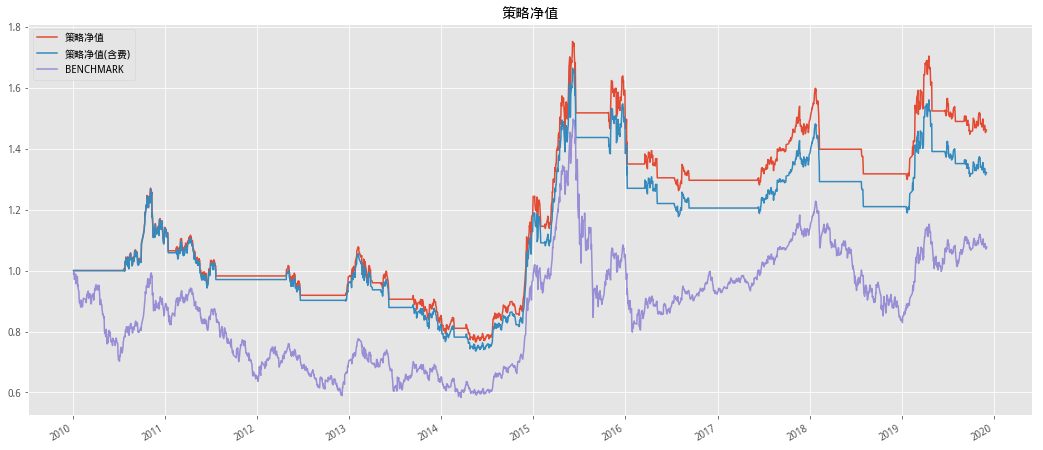

In [22]:
# HS300回测
# 沪深300ETF（510300.XSHG）从2012-05-28 使用研究模块回测与这个回测的含费收益差不多
Back_Testing(INDEX_ID, '2010-01-01', END, FEE, FastWindow, SlowWindow, ExtraPct,
             ChLen, TrailWindow, ReEntryWindow, ReEntryChLen, 'Cal_SMA', 'Double_Average').Summary()

#### WMA均线

,策略收益,策略收益(含费)
年化收益率,14.96%,13.91%
累计收益率,629.07%,539.56%
夏普比率,0.883929,0.828562
最大回撤,32.85%,33.67%
持仓总天数,1377,1377
交易次数,22,22
平均持仓天数,62.5909,62.5909
获利天数,795,788
亏损天数,582,589
胜率(按天),57.73%,57.23%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,6.75%,4.82%,5.82%,73.03%,116.12%
2006-12-31,126.11%,119.57%,13.82%,379.85%,912.82%
2007-12-31,126.17%,120.34%,20.90%,247.70%,603.61%
2008-12-31,-25.93%,-25.57%,31.98%,-129.69%,-81.07%
2009-12-31,48.02%,46.64%,24.95%,156.55%,192.52%
2010-12-31,4.18%,4.04%,12.80%,33.60%,32.65%
2011-12-31,-1.40%,-1.36%,6.24%,-14.64%,-22.41%
2012-12-31,6.53%,6.34%,0.54%,167.30%,1215.20%
2013-12-31,-10.90%,-10.41%,18.52%,-68.58%,-58.85%
2014-12-31,40.35%,39.40%,5.59%,229.08%,722.26%


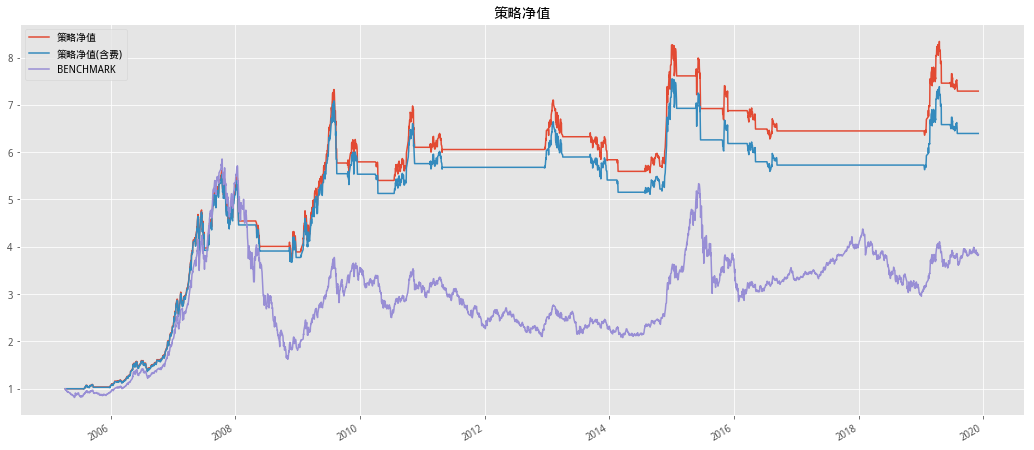

In [23]:
# HS300回测
Back_Testing(INDEX_ID, START, END, FEE, FastWindow, SlowWindow, ExtraPct,
             ChLen, TrailWindow, ReEntryWindow, ReEntryChLen, 'Cal_WMA', 'Double_Average').Summary()

#### EMA均线

,策略收益,策略收益(含费)
年化收益率,4.37%,3.55%
累计收益率,84.09%,64.48%
夏普比率,0.373275,0.316634
最大回撤,35.44%,37.76%
持仓总天数,1192,1192
交易次数,19,19
平均持仓天数,62.7368,62.7368
获利天数,650,646
亏损天数,541,545
胜率(按天),54.53%,54.19%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,0.95%,0.69%,5.82%,15.06%,16.39%
2006-12-31,36.56%,35.03%,10.50%,187.21%,348.27%
2007-12-31,14.11%,13.63%,15.22%,86.14%,92.74%
2008-12-31,-12.19%,-12.01%,17.33%,-115.25%,-70.35%
2009-12-31,54.86%,53.25%,20.78%,176.24%,264.07%
2010-12-31,-2.09%,-2.02%,14.19%,-3.44%,-14.72%
2011-12-31,-8.51%,-8.31%,14.74%,-68.43%,-57.69%
2012-12-31,-4.59%,-4.46%,10.38%,-55.67%,-44.21%
2013-12-31,-2.48%,-2.36%,11.20%,-14.96%,-22.11%
2014-12-31,51.08%,49.84%,7.13%,257.41%,716.49%


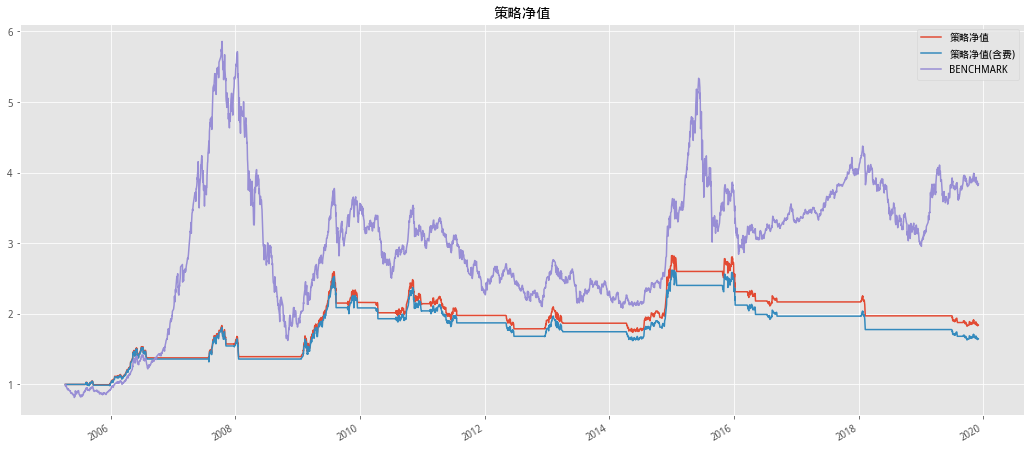

In [24]:
# HS300回测
Back_Testing(INDEX_ID, START, END, FEE, FastWindow, SlowWindow, ExtraPct, ChLen,
             TrailWindow, ReEntryWindow, ReEntryChLen, 'Cal_EMA',
             'Double_Average').Summary()

### 敏感性分析

In [25]:
# 获取参数
def Get_Pamars(FastWindow, ExtraPct):
    '''
    FastWindow 短周期
    ExtraPct 突破比率
    '''
    # 参数设置

    SlowWindow = 2 * FastWindow  # 长周期
    ChLen = FastWindow + 3  # 买入/卖出观察窗口
    TrailWindow = FastWindow - 1  # 跟踪止损窗口长度
    ReEntryWindow = 2 * FastWindow  # 出场到再度进场的最大间隔
    ReEntryChLen = FastWindow + 1  # 再进场通道突破周期

    return (FastWindow, SlowWindow, ExtraPct, ChLen, TrailWindow, ReEntryWindow,
            ReEntryChLen)


# 敏感分析
def Sensitivity_analysis(INDEX_ID, START, END, FEE, Cal_MA_Method, FastWindow,
                         ExtraPct):

    temp = []
    params = list(itertools.product(FastWindow, ExtraPct))
    '''
    写到这里发现算法有点问题，如果做敏感性分析，数据重复下载了N边，其实可以先缓存在重复调用计算
    所以造成参数多了会慢
    '''
    for x in params:
        # 获取参数
        FastWindow_, SlowWindow, ExtraPct_, ChLen, TrailWindow, ReEntryWindow, ReEntryChLen = Get_Pamars(
            x[0], x[1])

        df, position, _ = Back_Testing(INDEX_ID, START, END, FEE, FastWindow_,
                                       SlowWindow, ExtraPct_, ChLen,
                                       TrailWindow, ReEntryWindow, ReEntryChLen,
                                       Cal_MA_Method,
                                       'Double_Average').Get_Position
        # 前序计算期
        begin_step = max(ReEntryChLen, ReEntryWindow, TrailWindow, ChLen)

        ret = df['close'].pct_change().iloc[begin_step:]
        strategy_cum = (1 + ret.shift(-1) * position[begin_step:]).cumprod()
        benchmark = (1 + ret).cumprod()
        # 计算基准年化收益
        Benchmark_Annualized_Returns = benchmark.iloc[-2]**(250 /
                                                            len(benchmark)) - 1
        # 计算策略年化收益
        Total_Annualized_Returns = strategy_cum.dropna().iloc[-1]**(
            250 / len(strategy_cum.dropna())) - 1
        # 计算夏普
        Sharpe = (Total_Annualized_Returns - 0.04) / np.std(
            ret.shift(-1) * position[begin_step:])

        df = pd.DataFrame(
            {
                '年化收益率': Total_Annualized_Returns,
                '夏普比率': Sharpe,
                '基准年化收益': Benchmark_Annualized_Returns
            },
            index=['{}|{:.2%}'.format(FastWindow_, ExtraPct_)])
        temp.append(df)

    out_df = pd.concat(temp)
    out_df.index.names = ['FastWindow|ExtraPct']
    return out_df

In [26]:
# 因为参数在EMA上不是很实用所以对EMA做敏感性分析
SensiAna_df = Sensitivity_analysis(INDEX_ID, START, END, FEE, 'Cal_EMA',
                                   list(range(5, 31, 5)),
                                   list(np.arange(0.01, 0.08, 0.01)))
# 查看年化收益及夏普前五名的参数
SensiAna_df.sort_values('年化收益率,夏普比率'.split(','), ascending=False).head()

,年化收益率,夏普比率,基准年化收益
FastWindow|ExtraPct,,,
5|1.00%,0.182350,12.627270,0.098632
25|2.00%,0.167744,11.217450,0.098632
25|1.00%,0.166506,10.760133,0.098632
20|8.00%,0.166457,12.499065,0.098632
20|6.00%,0.166220,11.983889,0.098632


array([AxesSubplot(0.125,0.536818;0.775x0.343182),
       AxesSubplot(0.125,0.125;0.775x0.343182)], dtype=object)

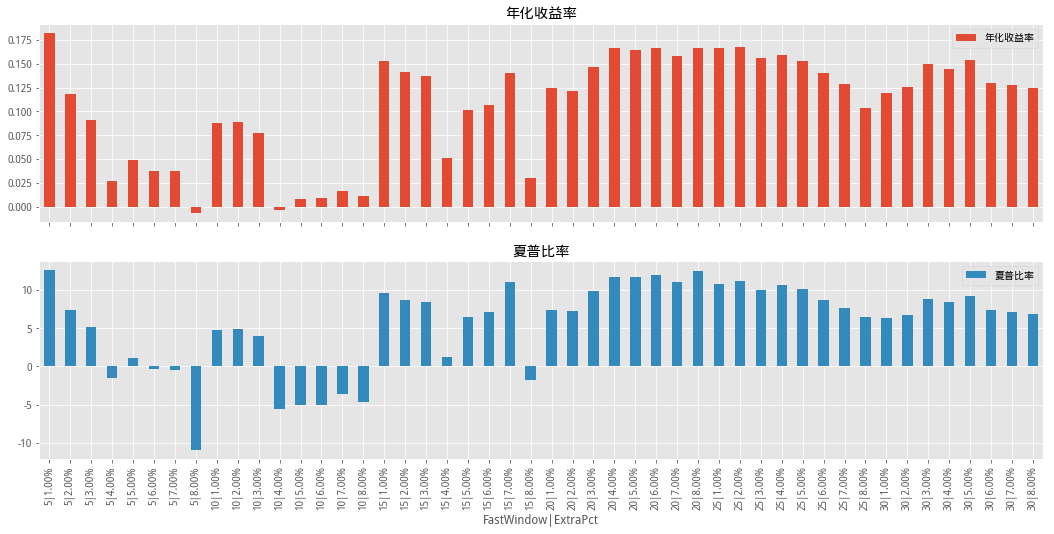

In [30]:
# 可视化详情
SensiAna_df['年化收益率,夏普比率'.split(',')].plot(
    kind='bar', subplots=True,figsize=(18,8))

,策略收益,策略收益(含费)
年化收益率,18.24%,16.63%
累计收益率,988.38%,796.09%
夏普比率,1.02962,0.948976
最大回撤,46.46%,47.77%
持仓总天数,1550,1550
交易次数,32,32
平均持仓天数,48.4375,48.4375
获利天数,907,900
亏损天数,643,650
胜率(按天),58.52%,58.06%


含费收益风险指标：


,年化收益率,累计收益率,最大回撤,夏普比率,Calmar比率
2005-12-31,9.43%,6.71%,5.48%,97.92%,172.14%
2006-12-31,113.40%,107.66%,17.49%,357.00%,648.22%
2007-12-31,147.54%,140.46%,15.76%,291.50%,936.25%
2008-12-31,-43.36%,-42.84%,47.77%,-230.91%,-90.78%
2009-12-31,24.01%,23.37%,18.68%,101.29%,128.55%
2010-12-31,6.86%,6.64%,12.80%,47.48%,53.63%
2011-12-31,-10.07%,-9.84%,13.67%,-98.46%,-73.68%
2012-12-31,8.40%,8.16%,7.59%,93.59%,110.80%
2013-12-31,1.87%,1.78%,10.66%,19.88%,17.51%
2014-12-31,47.30%,46.16%,4.83%,257.60%,978.39%


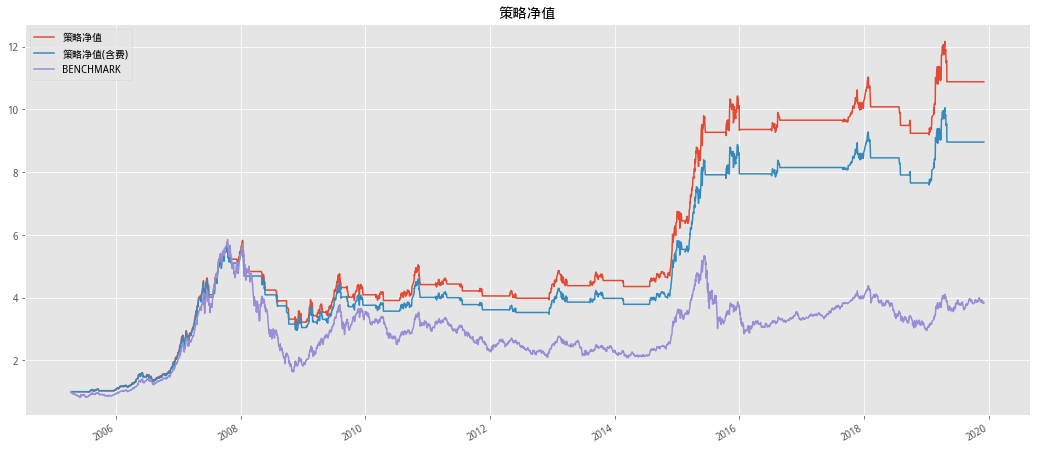

In [34]:
# 获取参数
FastWindow_, SlowWindow, ExtraPct_, ChLen, TrailWindow, ReEntryWindow, ReEntryChLen = Get_Pamars(5, 0.01)

# 回测
Back_Testing(INDEX_ID, START, END, FEE, FastWindow_, SlowWindow, ExtraPct_,
             ChLen, TrailWindow, ReEntryWindow, ReEntryChLen, 'Cal_EMA',
             'Double_Average').Summary()


## 构造自适应均线代码

**均线逻辑**

自适应均线的关键就在于，我们怎么判断目前是振荡行情，还是非振荡行情呢？我们可以这样判断，先计算两个数值：

N日净值变化 = 当前价 – N日前收盘价

假设X股票从20元连续4天每天上涨1元，当前价变成24元，则4日净值变化为24-20=4元。

N日净值波动 = SUM(ABS(当前价 – 前1日收盘价),N)，这个数学公式意思就是计算N日涨跌绝对值的总和。

假设Y股票从20元开始，每天涨跌分别为：1，-1，1，-1。那么4日后股价还是20元没变，但是4日净值波动却为4。

由此可以计算出一个涨跌的效率系数：

**效率系数 = N日净值变化 / N日净值波动**

两个极端情况是：如果连续上涨或下跌，则N日净值变化等于N日净值波动，那么效率系数为1；如果每涨一天再跌一天，而且涨跌一样多，那么N日净值变化就是0，所以效率系数也为0。当然大部分情况是效率系数在0和1之间，越是大涨大跌行情，效率系数越接近1，越是振荡行情，效率系数越接近0



作者：宜昌白云飞
链接：[宜昌白云飞](https://xueqiu.com/1884493065/130198267)

In [35]:
# 计算自适应均线
def cal_jxbl(data_df, N):
    '''
    N=10
    '''
    df = data_df.copy()
    df['jdzf'] = abs(df.close.diff())
    df['ljzf'] = df.jdzf.rolling(N).sum()
    df['zfbl'] = df.jdzf/df.ljzf
    df['syxs'] = df.zfbl*(2/3-2/31)+2/31
    df = df[N:]

    # 计算DMA
    def Cal_DMA(close, weighted):
        '''
        close:array
        wieghted：array
        ------
        return:list
        '''
        from functools import reduce

        def DMA_CN(close, weighted):
            return reduce(lambda x, y: (1 - y[1])*x + y[1]*y[0], zip(close, weighted), close[0])
        return list(map(lambda x: DMA_CN(close[:x], weighted), range(1, len(close) + 1)))

    df['zsjx'] = talib.EMA(
        np.array(Cal_DMA(df.close.values, (df.syxs**2).values)), 2)
    df['jxbl'] = df.zsjx/df.zsjx.shift(1)*100
    return df

**此部分为《广发证券-低延迟趋势线与择时》**

# 低延迟趋势线 LLT 的构造

上面有了EMA的基础我们现在来讲一下Z变换

Z 变换是信号处理中一种常用的时频变换方法，其本质是离散信号的拉普拉斯变 换。Z 变换定义为:
$$F(z)=\sum^{\infty}_{-\infty}f(k)z^{-k}$$

其中z 定义于复频域，f(k)是离散时间序列

有了Z变换就可以定义传输函数了，传输函数定义为输出信号Z变换与输入信 号 Z 变换的比值，可以看作输出、输入的强度比值。若将指数或价格的时间序列看作输入信号，均线指标看作输出信号，EMA 均线的传输函数即为：
$$H(z)=\frac{EMA(z)}{price(z)}$$

代入EMA公式，并借助Z变换的线性性质
$$\alpha_{1}f_{1}(k)+\alpha_{2}f_{2}(k) \leftrightarrow \alpha_{1}F_{1}(z)+\alpha_{2}F_{2}(z)$$
和时位移性质
$$f(k-m)\leftrightarrow z^{-m}F(z)$$
可以推导出EMA均线的传输函数为
$$H_1(z)=\frac{\alpha}{1-(1-\alpha)*z^{-1}}$$
传输函数是描述线性动力学系统的基本数学工具之一，它由动力学系统本身的性决定，与输入信号无关。传输函数可以描述不同频率下的输出输入比，即描述信号在动力学系统中的衰减或放大行为。 
若令$z=e^{iw}=e^{i\Omega T}=e^{i2\pi f_sT}$
Z变换在(1)式则转化为傅里叶变换，其中$f_s$为采样频率，T为采样时间间隔，此时可以更清晰地看出系统在频域中的性质。当z=1时，
